# Thesis Plots

# 0. Libraries, Auxiliary Functions

In [2]:
#libraries
import glob
import re
import os
import csv
import sys
import time
import math
import datetime


import numpy as np #arrays
import numpy.matlib as mat
import matplotlib.pyplot as plt #plotting
import matplotlib.mlab as ml
import matplotlib.colors as colors
import matplotlib as mpl

In [3]:
#inline plots (jupyter notebook)
%matplotlib inline
from platform import python_version
print(python_version())

2.7.11


In [4]:
#set figure size
plt.rcParams['figure.figsize'] = (9,7)
 
#latex font for plots
plt.rc('text', usetex=True)
plt.rc('font', family='serif',serif='cm10')

colors = [tuple(value/255. for value in rgb) for rgb in [(31,120,180),(166,206,227),(51,160,44),(178,223,138),(251,154,153),(253,191,111),(227,26,28)]]

#http://colorbrewer2.org
#colorblindfriendly
colors3 = [tuple(value/255. for value in rgb) for rgb in [(27,158,119),(217,95,2),(117,112,179)]]
colors4 = [tuple(value/255. for value in rgb) for rgb in [(166,206,227),(31,120,180),(178,223,138),(51,160,44)]]
#non-colorblindfriendly
colors7 = [tuple(value/255. for value in rgb) for rgb in [(31,120,180),(166,206,227),(51,160,44),(178,223,138),(251,154,153),(253,191,111),(227,26,28)]]
colors8dark = [tuple(value/255. for value in rgb) for rgb in [(27,158,119),(217,95,2),(117,112,179),(231,41,138),(102,166,30),(230,171,2),(166,118,29),(102,102,102)]]
colors8light = [tuple(value/255. for value in rgb) for rgb in [(141,211,199),(255,255,179),(190,186,218),(251,128,114),(128,177,211),(253,180,98),(179,222,105),(252,205,229)]]

In [5]:
#LOAD DATA
def load_data1(filename,data,param=None):
    """
    load data tored in the file of given name, read parameters in first two lines
    input: * filename
           * data (modified for output): 2-dim array containing all the data in the file
           * param (modified for output): dictionary containing parameter values, stored in the first two lines of file
    """
    
    #open file, read as csv
    datafile = open(filename, 'r')
    datareader = csv.reader(datafile)

    #read general parameters stored in first two lines
    if(not param is None):
        next(datareader)
        param_titles = next(datareader)
        param_values = next(datareader)
        for i,title in enumerate(param_titles):
            param[title.strip()] = int(param_values[i])

    #read data line by line from file
    for row in datareader:
        datarow = []
        #for each data element, try to cast to int, else try for float, else cast to string
        for elem in row:       
            try:
                datarow.append(int(elem))
            except ValueError:
                try: 
                    datarow.append(float(elem))
                except ValueError:
                    if len(str(elem).strip())>0: #only non-empty elements
                        datarow.append(str(elem).strip()) #remove whitespaces from beginning and end     
        if len(datarow)>0:
            data.append(datarow)

    datafile.close()
    
def get_current_header_index(old_index,firststring,headers):
    """
    starting from 'old_index'+1, go through the list of string-arrays 'headers' 
    and find the next array starting with 'firststring', 
    output None if not found
    """
    new_index = old_index
    rowfound = False
    while not rowfound:
        new_index += 1
        if new_index>=len(headers):
            #print firststring, 'header line was not found!'
            return None
        if headers[new_index][1][0].lower().startswith(firststring):
            rowfound = True
    return new_index

def load_data2(filenames,data,headers,param,param_twolines = True):
    """
    load data and headers stored in the file of given name, optionaly read parameters in first two lines
    input: * filename
           * data (modified for output): 2-dim array containing all the data in the file
           * headers (modified for output): list of the data rows containing strings in the beginning
               together with their indices in the data
           * param (modified for output): dictionary containing parameter values, stored in the first two lines of file,
               if None nothing is done
    """
    #possibly read data from multiple files
    if not type(filenames)==list:
        filename_out = filenames
        filenames = [filename_out]
    else:
        filename_out = filenames[0]
        
    ntrials = 0
    
    for filename in filenames:
        print filename
        #open file, read as csv
        datafile = open(filename, 'r')
        datareader = csv.reader(datafile)

        #optionally read general parameters stored in first two lines
        if param_twolines:
            param_titles = next(datareader)
            param_values = next(datareader)
            for i,title in enumerate(param_titles):
                param[title] = int(param_values[i])

        #read data line by line from file
        for row in datareader:
            datarow = []
            #for each data element, try to cast to int, else try for float, else cast to string
            for elem in row:       
                try:
                    datarow.append(int(elem))
                except ValueError:
                    try: 
                        datarow.append(float(elem))
                    except ValueError:
                        if len(str(elem).strip())>0: #only non-empty elements
                            datarow.append(str(elem).strip()) #remove whitespaces from beginning and end     
            if len(datarow)>0:
                data.append(datarow)
                if type(datarow[0])==str:
                    headers.append([len(data)-1,datarow])
                    #get parameters (raw output file)
                    if not param_twolines and datarow[0]=='# trials':
                        param_rowindex = len(data)-1
        
        #get parameters (raw output file)
        if not param_twolines:
            # read parameters
            for i,title in enumerate(data[param_rowindex]):
                param[title]=data[param_rowindex+1][i]
            ntrials += param['# trials']
        datafile.close()
    if len(filenames)>1:
        now = datetime.datetime.now()
        psuffix = ''
        if param['periodic']==1:
            psuffix = '_p'
        
        filename_out = '../output/output'+str(param['dim'])+'_%d-%d-%d_%d_%d'\
        %(now.year,now.month,now.day,param['window size'],ntrials)+psuffix+'_multi.txt'\
    
    if not param_twolines:
        param['# trials']=ntrials
    
    return filename_out

def get_next_row_starting_with(old_index,firststring,data):
    """
    starting from 'old_index'+1, go through the data 
    and find the next row starting with 'firststring', 
    output None if not found
    """
    new_index = old_index
    rowfound = False
    while not rowfound:
        new_index += 1
        if new_index>=len(data):
            #print firststring, 'data line was not found!'
            return None
        if data[new_index][0].lower().startswith(firststring):
            rowfound = True
    return new_index

def get_next_data_value(old_index,firststring,data):
    """
    same as get_next_row_starting_with, but also outputs the 
    second entry of the row starting with the input string
    """
    new_index = get_next_row_starting_with(old_index,firststring,data)
    if not new_index is None:
        if len(data[new_index])>1:
            return new_index, data[new_index][1]
        else: 
            return None, None
    else:
        return None, None

# 1. Dynamic Updates

 produce data with: './wrap_2_3 test_dynamic_runtime [dim] [window_size] [lambda] [num_trials] [periodic?] [draw?]'

In [6]:
#load and process raw data

def load_output_data_dynamic(filename, row=0):
    """
    load all data from output file of wrap_2_3
     input:  * filename
     output: * param: dictionary containing parameter values 'dim', '# trials', 'window size', 'periodic', 'lambda'
             * dynamic and static runtimes
    """
    t0 = time.clock()
    
    param = {} #dictionary for parameters
    data = [] #all data will be stored in this
    
    load_data1(filename,data,param) 
    
    #initialize arrays
    t_add_local = []
    t_add_global = []
    t_delete_local = [] 
    t_delete_global = []
    
    #for every trial
    current_row_index = 0
    for i in range(param['# trials']):
        current_row_index += 3
        if len(data[current_row_index])<2:
            current_row_index +=1
        t_add_local.append(data[current_row_index][1])
        t_add_global.append(data[current_row_index+1][1])
        current_row_index += 4
        t_delete_local.append(data[current_row_index][1])
        t_delete_global.append(data[current_row_index+1][1])
        current_row_index += 3
        
        

    #duration = time.clock() - t0; print 'time elapsed: %.4f' % duration
    
    return t_add_local, t_add_global, t_delete_local, t_delete_global, param

In [11]:
def get_mean_times_dynamic(directory,row=0):

    window_sizes = []
    num_trials = []
    t_add_local_means = []
    t_add_global_means = []
    t_delete_local_means = []
    t_delete_global_means = []
    t_add_local_stds = []
    t_add_global_stds = []
    t_delete_local_stds = []
    t_delete_global_stds = []
    
    for root, dirs, files in os.walk(directory):
        for filename in files:
            t_add_local, t_add_global, t_delete_local, t_delete_global, param = load_output_data_dynamic(directory+filename,row)
            window_sizes.append(param['window size'])
            num_trials.append(param['# trials'])
            t_add_local_means.append(np.mean(t_add_local))
            t_add_local_stds.append(np.std(t_add_local))
            t_add_global_means.append(np.mean(t_add_global))
            t_add_global_stds.append(np.std(t_add_global))
            t_delete_local_means.append(np.mean(t_delete_local))
            t_delete_local_stds.append(np.std(t_delete_local))
            t_delete_global_means.append(np.mean(t_delete_global))
            t_delete_global_stds.append(np.std(t_delete_global))
            
    return [t_add_local_means, t_add_global_means, t_delete_local_means, t_delete_global_means],\
            [t_add_local_stds, t_add_global_stds, t_delete_local_stds, t_delete_global_stds],\
            ['local addition','global addition','local deletion','global deletion'], window_sizes, num_trials
        
def plot_mean_times_dynamic(filename,dim=2,row=0):
    means, stds, titles, window_sizes, num_trials = get_mean_times_dynamic(filename,row)
    print 'mean times'
    for i in range(len(window_sizes)):
        print str(window_sizes[i])+'^2: '+str(means[0][i])+', '+str(means[1][i])+', '+str(means[2][i])+', '+str(means[3][i])
    
    perm = np.argsort(window_sizes)
    for i,title in enumerate(titles):
        if(dim==2):
            plt.errorbar([window_sizes[p]*window_sizes[p] for p in perm],[means[i][p] for p in perm],yerr=[stds[i][p] for p in perm],lw=3,label=title.replace('_','\_'),elinewidth=3,color=colors[i])
        else:
            plt.errorbar([window_sizes[p]*window_sizes[p]*window_sizes[p] for p in perm],[means[i][p] for p in perm],yerr=[stds[i][p] for p in perm],lw=3,label=title.replace('_','\_'),elinewidth=3,color=colors[i])
    ax = plt.gca()
    ax.legend(fontsize=20,loc='upper left')
    plt.title('Runtime comparison for PPP',fontsize=30)
    #plt.xlim(np.min(window_sizes)-np.max(window_sizes)*0.05,np.max(window_sizes)*1.05)
    plt.xlabel('exp \# points',fontsize=30)
    plt.ylabel('time [s]',fontsize=30)
    plt.tick_params(axis='both', which='major', labelsize=20)
    
def plot_times_dynamic_ppp_23(directory2,directory3,output_directory,row=0):
    means2, stds2, titles2, window_sizes2, num_trials2 = get_mean_times_dynamic(directory2,row)
    means3, stds3, titles3, window_sizes3, num_trials3 = get_mean_times_dynamic(directory3,row)
    perm2 = np.argsort(window_sizes2)
    perm3 = np.argsort(window_sizes3)
    
    plt.errorbar([window_sizes3[p]*window_sizes3[p]*window_sizes3[p] for p in perm3],[means3[1][p] for p in perm3],yerr=[stds3[1][p] for p in perm3],lw=5,label='recomputing 3D',elinewidth=3,color=colors[3],linestyle='dashed',fmt='o', capsize=0)
    plt.errorbar([window_sizes3[p]*window_sizes3[p]*window_sizes3[p] for p in perm3],[means3[0][p] for p in perm3],yerr=[stds3[0][p] for p in perm3],lw=5,label='point insertion 3D',elinewidth=3,color=colors[2],linestyle='-',fmt='o', capsize=0)
    plt.errorbar([window_sizes2[p]*window_sizes2[p] for p in perm2],[means2[1][p] for p in perm2],yerr=[stds2[1][p] for p in perm2],lw=5,label='recomputing 2D',elinewidth=3,color=colors[1],linestyle='dashed',fmt='o', capsize=0)
    plt.errorbar([window_sizes2[p]*window_sizes2[p] for p in perm2],[means2[0][p] for p in perm2],yerr=[stds2[0][p] for p in perm2],lw=5,label='point insertion 2D',elinewidth=3,color=colors[0],linestyle='-',fmt='o', capsize=0)
    
    ax = plt.gca()
    ax.legend(fontsize=30,loc='upper left')
    #plt.title('Runtime comparison for PPP',fontsize=30)
    plt.xlim(0,(np.max(window_sizes2)**2)*1.05) 
    plt.xlabel('expected \# points',fontsize=40)
    plt.ylabel('time [s]',fontsize=40)
    plt.tick_params(axis='both', which='major', labelsize=30)
    #plt.savefig('../output/test.svg')
    plt.savefig(output_directory+'/dynamic_updates_runtimes.eps', bbox_inches='tight', format='eps', dpi=1000)
    plt.show()

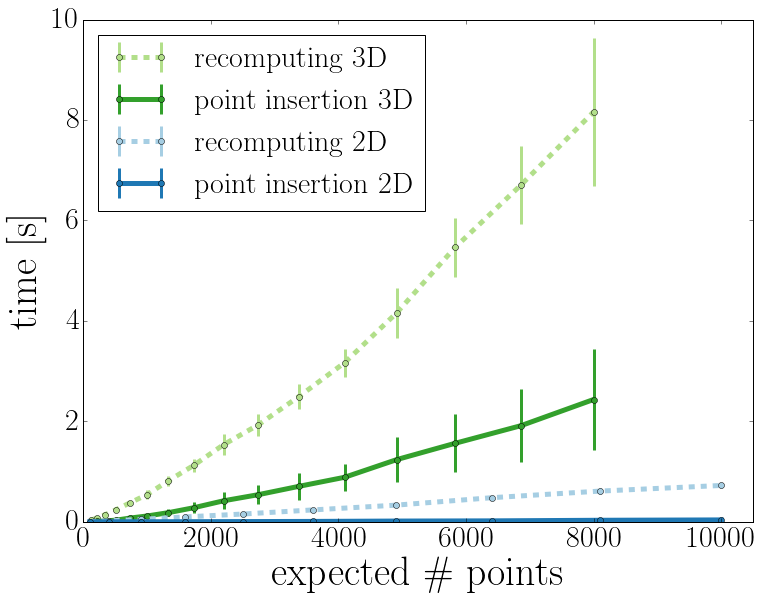

In [12]:
plt.rcParams['figure.figsize'] = (12,9)
plot_times_dynamic_ppp_23('../output/dynamic_times_ppp2/','../output/dynamic_times_ppp3/','../screenshots/thesis/')
plt.rcParams['figure.figsize'] = (9,7)

# 2. Combinatorial and topological statistics

 produce data with: './wrap_2_3 ppp [dim] [window_size] [lambda] [num_trials] [periodic?] [draw?]'

## Load raw data and process

In [7]:
#load and process raw data

def load_output_data_ppp(filename):
    """
    load all data from output file of wrap_2_3
     input:  * filename
     output: * param: dictionary containing parameter values 'dim', '# trials', 'window size', 'periodic', 'lambda'
             * [full_header,full_data]: data about full Alpha and Wrap complex (#trials, len(header))-array, 
                 header contains column titles
             * [interval_header, interval_data]: data about each interval, more for singular intervals, header contains titles
             * [overlapping_data, overlapping_header]: data about intervals in overlapping lower sets
    """
    t0 = time.clock()
    
    param = {} #dictionary for parameters
    data = [] #all data will be stored in this
    headers = [] #this array will store rows containing strings together with their row index
    
    filename = load_data2(filename,data,headers,param,False)
    print filename 
    
    #initialize arrays
    full_data = []
    alpha_data = []
    interval_data = [] 
    overlapping_data = []
    
    #for every trial
    current_header_index = 0
    for i in range(param['# trials']):
        
        #get data independent of alpha: # points, # intervals
        # get row index
        if current_header_index+6 < len(headers): #stop if any trial info not complete
            current_header_index = get_current_header_index(current_header_index,'# points',headers)
            header = headers[current_header_index][1]
            rowindex = headers[current_header_index][0]+1
            # save header
            if i==0:
                full_header = header
            # get data
            full_data.append(data[rowindex])

            #get data for every interval: r_alpha, r_wrap, lower dimension, upper dimension
            # for singular intervals also: positive?, persistence, # simplices in lower set, # nested lower sets, diameter of simplex, diameter of lower set
            # get first row index
            current_header_index = get_current_header_index(current_header_index,'r_alpha',headers)
            header = headers[current_header_index][1]
            rowindex = headers[current_header_index][0]+1    
            # save header
            if i==0:
                interval_header = header
            # get data
            if current_header_index+1<len(headers):
                interval_data.append(data[rowindex:headers[current_header_index+1][0]])
            else: #last trial
                interval_data.append(data[rowindex:])        

            #get data about overlapping of lower sets
            next_index = get_current_header_index(current_header_index,'overlapping lower sets',headers)
            if not next_index is None:
                current_header_index = next_index+1
                header = headers[current_header_index][1]
                rowindex = headers[current_header_index][0]+1    
                # save header
                if i==0:
                    overlapping_header = header
                # get data
                if current_header_index+1<len(headers):
                    overlapping_data.append(data[rowindex:headers[current_header_index+1][0]])
                else: #last trial
                    overlapping_data.append(data[rowindex:])
    
    # compute # intervals and #simplices of various types in full complex (constants 'c','d') and add to full_data
    full_header.extend(['c_11','c_22','c_33','c_12','c_23','c_13','d_1','d_2','d_3','d_sum'])
    expected_num_points = param['lambda']*param['window size']**param['dim']
    for trial in range(len(interval_data)):
        #extract columns of dimensions
        lower_upper_dims = [interval_data_row[2:4] for interval_data_row in interval_data[trial]]
        c00 = full_data[trial][0]
        c11 = lower_upper_dims.count([1,1])
        c22 = lower_upper_dims.count([2,2])
        c33 = lower_upper_dims.count([3,3])
        c12 = lower_upper_dims.count([1,2])
        c23 = lower_upper_dims.count([2,3])
        c13 = lower_upper_dims.count([1,3])
        d1 = c11 + c12 + c13
        d2 = c22 + c12 + c23 + 2*c13
        d3 = c33 + c23 + c13
        dsum = c00 + d1 + d2 + d3
        full_data[trial].extend([c11,c22,c33,c12,c23,c13,d1,d2,d3,dsum])
        
    # convert arrays to np
    full_data = np.array(full_data,dtype=object)
    interval_data = np.array(interval_data,dtype=object)
    overlapping_data = np.array(overlapping_data,dtype=object)

    duration = time.clock() - t0; print 'time elapsed: %.4f' % duration
    
    return filename, param, [full_header,full_data], [interval_header,interval_data], [overlapping_header,overlapping_data] 

In [7]:
# write info about full complex (# intervals of various types) for every trial to file
def save_full_data(filename, param, full_header, full_data):
    """
    write info about full complex (# intervals of various types) for every trial to file
     input: * filename (of input data)
            * param: dictionary containing parameter values 'dim', '# trials', 'window size', 'periodic', 'lambda'
            * full_header,full_data: data about full complex (#trials, len(header))-array, 
                 header contains column titles
     output file: filename + '_full.txt'
    """
    output_filename = os.path.splitext(filename)[0]+'_full.txt' 
    with open(output_filename, 'wb') as csvfile: #'wb' instead of 'w' to avoid additional line breaks
        writer = csv.writer(csvfile, delimiter=',')
        writer.writerow(param.keys())
        writer.writerow(param.values())
        writer.writerow(full_header)
        for i,trial_data in enumerate(full_data):
            writer.writerow(trial_data.tolist())
    print output_filename
    
#some data is not saved since it can be computed from other:
# Betti_0 = 1 -> # neg crit edges = # points - 1
# Betti_1 = 0 -> # pos crit edges = # neg crit triangles
# Betti_2 = 0 -> # pos crit triangles = # neg crit tetrahedra

In [8]:
def compute_densities(filename, interval_header, interval_data, full_header, full_data, param, r_min=0, r_max=2.5, r_num=250):
    """
    compute discretized densities of desired data over alpha and wrap filtration
     input: * interval_header, interval_data: extracted from output data
            * param: dictionary containing parameter values 'dim', '# trials', 'window size', 'periodic', 'lambda'
            * r_min, r_max, r_num => compute bins np.linspace(r_min,r_max,r_num+1)
     output: densities written to file
    """
    #compute bins
    r_bins = np.linspace(r_min,r_max,r_num+1)
    r_bincenters = (r_bins[1:]+r_bins[:-1])*0.5
    
    expected_num_points = param['lambda']*param['window size']**param['dim']
    dim = param['dim']
    
    #initialize arrays of desired data
    #*intervals of different types
    densities_intervals_alpha = []
    densities_intervals_wrap = []
    if dim==3:
        types_intervals = [[1,1],[2,2],[3,3],[1,2],[2,3],[1,3]]
    else:
        types_intervals = [[1,1],[2,2],[1,2]]
    #*critical simplices, type = (dim, dim, pos?)
    densities_critical = []
    if dim==3:
        types_critical = [[1,1,0],[1,1,1],[2,2,0],[2,2,1],[3,3,0]]
    else:
        types_critical = [[1,1,0],[1,1,1],[2,2,0]]
    #*simplices of different dim
    densities_simplices_alpha = []
    densities_simplices_wrap = []
    if dim==3:
        dims = [1,2,3]
    else:
        dims = [1,2]
    #*Betti numbers
    curves_betti = []
    
    #compute densities over binned filtration values from interval data
    for trial in range(len(interval_data)):
        densities_intervals_alpha_trial = []
        densities_intervals_wrap_trial = []
        densities_critical_trial = []
        densities_simplices_alpha_trial = []
        densities_simplices_wrap_trial = []
        curves_betti_trial = []
        
        #directly from data
        #*intervals of different types
        for typ in types_intervals:
            #get filtration values of desired data
            r_alpha = np.array([interval_data_row[0] for interval_data_row in interval_data[trial] if interval_data_row[2:4]==typ])
            r_wrap = np.array([interval_data_row[1] for interval_data_row in interval_data[trial] if interval_data_row[2:4]==typ])
            #compute density = histogram
            density = np.histogram(r_alpha,bins = r_bins)[0]
            densities_intervals_alpha_trial.append(density)
            density = np.histogram(r_wrap,bins = r_bins)[0]
            densities_intervals_wrap_trial.append(density)
        #*critical simplices, type = (dim, dim, pos?)
        for typ in types_critical:
            #get filtration values of desired data
            r_alphawrap = np.array([interval_data_row[0] for interval_data_row in interval_data[trial] if interval_data_row[2:5]==typ])
            #compute density = histogram
            density = np.histogram(r_alphawrap,bins = r_bins)[0]
            densities_critical_trial.append(density)
        
        #from already computed densities
        #*simplices of different dim
        for di in dims:
            if di==1:
                density_alpha = densities_intervals_alpha_trial[types_intervals.index([1,1])]+\
                          densities_intervals_alpha_trial[types_intervals.index([1,2])]
                if dim==3:
                    density_alpha += densities_intervals_alpha_trial[types_intervals.index([1,3])]
                
                density_wrap = densities_intervals_wrap_trial[types_intervals.index([1,1])]+\
                          densities_intervals_wrap_trial[types_intervals.index([1,2])]
                if dim==3:
                    density_wrap += densities_intervals_wrap_trial[types_intervals.index([1,3])]
                
            elif di==2:
                density_alpha = densities_intervals_alpha_trial[types_intervals.index([2,2])]+\
                          densities_intervals_alpha_trial[types_intervals.index([1,2])]
                if dim==3:
                    density_alpha += densities_intervals_alpha_trial[types_intervals.index([2,3])]+\
                          densities_intervals_alpha_trial[types_intervals.index([1,3])]*2
                density_wrap = densities_intervals_wrap_trial[types_intervals.index([2,2])]+\
                          densities_intervals_wrap_trial[types_intervals.index([1,2])]
                if dim==3:
                    density_wrap += densities_intervals_wrap_trial[types_intervals.index([2,3])]+\
                          densities_intervals_wrap_trial[types_intervals.index([1,3])]*2
            elif di==3:
                density_alpha = densities_intervals_alpha_trial[types_intervals.index([3,3])]+\
                          densities_intervals_alpha_trial[types_intervals.index([2,3])]+\
                          densities_intervals_alpha_trial[types_intervals.index([1,3])]
                density_wrap = densities_intervals_wrap_trial[types_intervals.index([3,3])]+\
                          densities_intervals_wrap_trial[types_intervals.index([2,3])]+\
                          densities_intervals_wrap_trial[types_intervals.index([1,3])]
            densities_simplices_alpha_trial.append(density_alpha)
            densities_simplices_wrap_trial.append(density_wrap)
        #*Betti numbers
        for di in dims:
            d=di-1
            if d==0:
                num_points = full_data[trial][full_header.index('# points')]
                curve = num_points - np.cumsum(densities_critical_trial[types_critical.index([1,1,0])])
            elif d==1:
                curve = np.cumsum(densities_critical_trial[types_critical.index([1,1,1])])\
                        -np.cumsum(densities_critical_trial[types_critical.index([2,2,0])])
            elif d==2:
                curve = np.cumsum(densities_critical_trial[types_critical.index([2,2,1])])\
                        -np.cumsum(densities_critical_trial[types_critical.index([3,3,0])])
            curves_betti_trial.append(curve)
       
        densities_intervals_alpha.append(densities_intervals_alpha_trial)
        densities_intervals_wrap.append(densities_intervals_wrap_trial)
        densities_critical.append(densities_critical_trial)
        densities_simplices_alpha.append(densities_simplices_alpha_trial)
        densities_simplices_wrap.append(densities_simplices_wrap_trial)
        curves_betti.append(curves_betti_trial)
    
    #compute mean and variance over trials
    densities_intervals_alpha_mean = np.mean(np.array(densities_intervals_alpha),axis=0)
    densities_intervals_alpha_var = np.var(np.array(densities_intervals_alpha),axis=0)
    densities_intervals_wrap_mean = np.mean(np.array(densities_intervals_wrap),axis=0)
    densities_intervals_wrap_var = np.var(np.array(densities_intervals_wrap),axis=0)
    densities_critical_mean = np.mean(np.array(densities_critical),axis=0)
    densities_critical_var = np.var(np.array(densities_critical),axis=0)
    densities_simplices_alpha_mean = np.mean(np.array(densities_simplices_alpha),axis=0)
    densities_simplices_alpha_var = np.var(np.array(densities_simplices_alpha),axis=0)
    densities_simplices_wrap_mean = np.mean(np.array(densities_simplices_wrap),axis=0)
    densities_simplices_wrap_var = np.var(np.array(densities_simplices_wrap),axis=0)
    curves_betti_mean = np.mean(np.array(curves_betti),axis=0)
    curves_betti_var = np.var(np.array(curves_betti),axis=0)
    
    densities_intervals_alpha_cumvar = np.var(np.cumsum(np.array(densities_intervals_alpha),axis=2),axis=0)
    densities_intervals_wrap_cumvar = np.var(np.cumsum(np.array(densities_intervals_wrap),axis=2),axis=0)
    densities_critical_cumvar = np.var(np.cumsum(np.array(densities_critical),axis=2),axis=0)
    densities_simplices_alpha_cumvar = np.var(np.cumsum(np.array(densities_simplices_alpha),axis=2),axis=0)
    densities_simplices_wrap_cumvar = np.var(np.cumsum(np.array(densities_simplices_wrap),axis=2),axis=0)
    
    #store to file
    output_filename = os.path.splitext(filename)[0]+'_densities.txt' 
    with open(output_filename, 'wb') as csvfile: #'wb' instead of 'w' to avoid additional line breaks
        writer = csv.writer(csvfile, delimiter=',')
        #parameters
        writer.writerow(param.keys())
        writer.writerow(param.values())
        #bins of filtration values
        writer.writerow(['r_bins:', ' min',' max',' num'])
        writer.writerow([r_min,r_max,r_num])
        
        #data curves: mean and variances
        #*intervals of different types
        writer.writerow([])
        writer.writerow(['# intervals (Delaunay complex)'])
        for i,typ in enumerate(types_intervals):
            writer.writerow(['type'])
            writer.writerow(typ)
            writer.writerow(['mean over trials'])
            writer.writerow(densities_intervals_alpha_mean[i])
            writer.writerow(['variance of pdf'])
            writer.writerow(densities_intervals_alpha_var[i])
            writer.writerow(['variance of cdf'])
            writer.writerow(densities_intervals_alpha_cumvar[i])
            writer.writerow([])
        writer.writerow(['# intervals (Wrap complex)'])
        for i,typ in enumerate(types_intervals):
            writer.writerow(['type'])
            writer.writerow(typ)
            writer.writerow(['mean over trials'])
            writer.writerow(densities_intervals_wrap_mean[i])
            writer.writerow(['variance of pdf'])
            writer.writerow(densities_intervals_wrap_var[i])
            writer.writerow(['variance of cdf'])
            writer.writerow(densities_intervals_wrap_cumvar[i])
        #*critical simplices, type = (dim, dim, pos?)
        writer.writerow([])
        writer.writerow(['# critical simplices'])
        for i,typ in enumerate(types_critical):
            writer.writerow(['type'])
            writer.writerow(typ)
            writer.writerow(['mean over trials'])
            writer.writerow(densities_critical_mean[i])
            writer.writerow(['variance of pdf'])
            writer.writerow(densities_critical_var[i])
            writer.writerow(['variance of cdf'])
            writer.writerow(densities_critical_cumvar[i])
        #*simplices of different dim    
        writer.writerow([])
        writer.writerow(['# simplices (Delaunay complex)'])
        for i,di in enumerate(dims):
            writer.writerow(['dim'])
            writer.writerow([di])
            writer.writerow(['mean over trials'])
            writer.writerow(densities_simplices_alpha_mean[i])
            writer.writerow(['variance of pdf'])
            writer.writerow(densities_simplices_alpha_var[i])
            writer.writerow(['variance of cdf'])
            writer.writerow(densities_simplices_alpha_cumvar[i])
        writer.writerow([])
        writer.writerow(['# simplices (Wrap complex)'])
        for i,di in enumerate(dims):
            writer.writerow(['dim'])
            writer.writerow([di])
            writer.writerow(['mean over trials'])
            writer.writerow(densities_simplices_wrap_mean[i])
            writer.writerow(['variance of pdf'])
            writer.writerow(densities_simplices_wrap_var[i])
            writer.writerow(['variance of cdf'])
            writer.writerow(densities_simplices_wrap_cumvar[i])
        #*Betti numbers
        writer.writerow([])
        writer.writerow(['Betti numbers'])
        for i,di in enumerate(dims):
            writer.writerow(['dim'])
            writer.writerow([di-1])
            writer.writerow(['mean over trials'])
            writer.writerow(curves_betti_mean[i])
            writer.writerow(['variance'])
            writer.writerow(curves_betti_var[i])
        
    print output_filename   

In [9]:
def compute_lowersets(filename, interval_header, interval_data, param, numsimp_max = 1000, diam_max = 50., diam_nbins = 250):
    """
    compute distribution of lower set size
     input: * interval_header, interval_data: extracted from output data
            * param: dictionary containing parameter values 'dim', '# trials', 'window size', 'periodic', 'lambda'
     output: distributions written to file
    """
    dim = param['dim']
    #types of singular intervals (dim, dim, pos?), disregarding pos/neg if len==2, all if == [0]
    if dim==3:
        types_lowersets = [[0],[1,1],[2,2],[3,3],[1,1,0],[1,1,1],[2,2,0],[2,2,1],[3,3,0]]
    else:
        types_lowersets = [[0],[1,1],[2,2],[1,1,0],[1,1,1],[2,2,0]]
    
    percentiles = [75,50,25,10,5,1]
    
    #initialize data arrays
    distr_numsimp = []
    distr_diam = []
    max_numsimp = []
    max_diam = []
    corr_numsimp_r = []
    corr_diam_r = []
    percentiles_numsimp = []
    percentiles_diam = []
    
    diam_bins = np.linspace(0,diam_max,diam_nbins+1)
        
    #get data for every trial
    for trial in range(len(interval_data)):
        distr_numsimp_trial = []
        distr_diam_trial = []
        max_numsimp_trial = []
        max_diam_trial = []
        corr_numsimp_r_trial = []
        corr_diam_r_trial = []
        percentiles_numsimp_trial = []
        percentiles_diam_trial = []
        
        for typ in types_lowersets:
            #extract lower set size (# simplices and diamter) for all singular intervals of this type
            #print [row[2:5] for row in singular_intervals]
            if len(typ)==3:
                singular_intervals_type = np.array([row for row in interval_data[trial] if len(row)>4 and row[2:5]==typ])
            elif len(typ)==2:
                singular_intervals_type = np.array([row for row in interval_data[trial] if len(row)>4 and row[2:4]==typ])
            elif len(typ)==1:
                singular_intervals_type = np.array([row for row in interval_data[trial] if len(row)>4])
            rs = singular_intervals_type[:,0]
            numsimp_trial = singular_intervals_type[:,6]
            diam_trial = singular_intervals_type[:,8]
            
            #compute histogram, maximum, correlations and percentiles
            hist = np.histogram(numsimp_trial,bins=range(numsimp_max+1))[0]
            distr_numsimp_trial.append(hist)
            hist = np.histogram(diam_trial,bins=diam_bins)[0]
            distr_diam_trial.append(hist)
            
            max_numsimp_trial.append(np.max(numsimp_trial))
            max_diam_trial.append(np.max(diam_trial))
            
            corr = np.corrcoef(rs,numsimp_trial)[0,1]
            corr_numsimp_r_trial.append(corr)
            corr = np.corrcoef(rs,diam_trial)[0,1]
            corr_diam_r_trial.append(corr)
            
            perc = np.array([np.percentile(np.array(numsimp_trial),100-p) for p in percentiles])
            percentiles_numsimp_trial.append(perc)
            perc = np.array([np.percentile(np.array(diam_trial),100-p) for p in percentiles])
            percentiles_diam_trial.append(perc)
         
        distr_numsimp.append(distr_numsimp_trial)
        distr_diam.append(distr_diam_trial)
        max_numsimp.append(max_numsimp_trial)
        max_diam.append(max_diam_trial)
        corr_numsimp_r.append(corr_numsimp_r_trial)
        corr_diam_r.append(corr_diam_r_trial)
        percentiles_numsimp.append(percentiles_numsimp_trial)
        percentiles_diam.append(percentiles_diam_trial)
      
    #percentiles over full data (not mean over trials)
    percentiles_numsimp_all = []
    percentiles_diam_all = []
    for typ in types_lowersets:
        numsimp_all = []
        diam_all = []
        for trial in range(len(interval_data)):
            if len(typ)==3:
                singular_intervals_type = np.array([row for row in interval_data[trial] if len(row)>4 and row[2:5]==typ])
            elif len(typ)==2:
                singular_intervals_type = np.array([row for row in interval_data[trial] if len(row)>4 and row[2:4]==typ])
            elif len(typ)==1:
                singular_intervals_type = np.array([row for row in interval_data[trial] if len(row)>4])
            rs = singular_intervals_type[:,0]
            numsimp_trial = singular_intervals_type[:,6]
            diam_trial = singular_intervals_type[:,8]
            numsimp_all.extend(numsimp_trial)
            diam_all.extend(diam_trial)
        perc = np.array([np.percentile(np.array(numsimp_all),100-p) for p in percentiles])
        percentiles_numsimp_all.append(perc)
        perc = np.array([np.percentile(np.array(diam_all),100-p) for p in percentiles])
        percentiles_diam_all.append(perc)
        
    #compute mean over trials
    distr_numsimp_mean = np.mean(np.array(distr_numsimp),axis=0)
    distr_diam_mean = np.mean(np.array(distr_diam),axis=0)
    max_numsimp_mean = np.mean(np.array(max_numsimp),axis=0)
    max_diam_mean = np.mean(np.array(max_diam),axis=0)
    max_numsimp_max = np.max(np.array(max_numsimp),axis=0)
    max_diam_max = np.max(np.array(max_diam),axis=0)
    corr_numsimp_r_mean = np.mean(corr_numsimp_r, axis=0)
    corr_diam_r_mean = np.mean(corr_diam_r, axis=0)
    percentiles_numsimp_mean = np.mean(percentiles_numsimp, axis=0)
    percentiles_diam_mean = np.mean(percentiles_diam, axis=0)
    
    #store to file
    output_filename = os.path.splitext(filename)[0]+'_lowerset.txt' 
    with open(output_filename, 'wb') as csvfile: #'wb' instead of 'w' to avoid additional line breaks
        writer = csv.writer(csvfile, delimiter=',')
        #parameters
        writer.writerow(param.keys())
        writer.writerow(param.values())
        writer.writerow([])
        writer.writerow(['percentiles'])
        writer.writerow(percentiles)
        
        #distribution of lower set sizes
        #*# simplices
        writer.writerow([])
        writer.writerow(['# simplices'])
        writer.writerow(['max, nbins'])
        writer.writerow([numsimp_max, numsimp_max])
        for i,typ in enumerate(types_lowersets):
            writer.writerow(['type'])
            writer.writerow(typ)
            writer.writerow(['mean distribution over trials'])
            writer.writerow(distr_numsimp_mean[i])
            writer.writerow(['correlation with r'])
            writer.writerow([corr_numsimp_r_mean[i]])
            writer.writerow(['mean percentiles'])
            writer.writerow(percentiles_numsimp_mean[i])
            writer.writerow(['percentiles over all trials'])
            writer.writerow(percentiles_numsimp_all[i])
            writer.writerow(['max: avg','max over trials'])
            writer.writerow([max_numsimp_mean[i],max_numsimp_max[i]])
        #*diameter
        writer.writerow([])
        writer.writerow(['diameter'])
        writer.writerow(['max, nbins'])
        writer.writerow([diam_max, diam_nbins])
        for i,typ in enumerate(types_lowersets):
            writer.writerow(['type'])
            writer.writerow(typ)
            writer.writerow(['mean distribution over trials'])
            writer.writerow(distr_diam_mean[i])
            writer.writerow(['correlation with r'])
            writer.writerow([corr_diam_r_mean[i]])
            writer.writerow(['mean percentiles'])
            writer.writerow(percentiles_diam_mean[i])
            writer.writerow(['percentiles over all trials'])
            writer.writerow(percentiles_diam_all[i])
            writer.writerow(['max: avg','max over trials'])
            writer.writerow([max_diam_mean[i],max_diam_max[i]])
    print output_filename

In [10]:
# one function to load raw data and store processed data to files
def process_data(filename):
    # load raw data
    filename, param, [full_header,full_data], [interval_header,interval_data], [overlapping_header,overlapping_data]  \
    = load_output_data_ppp(filename)
    dim = param['dim']
    expected_num_points = param['lambda']*param['window size']**param['dim']
    print param
    # store data about full complex
    save_full_data(filename, param, full_header, full_data)
    # Compute empirical densities (histograms over bins of filtration values)
    #    different interval types over alpha and wrap filtration, simplices of different dim over alpha and wrap filtration,
    #    Betti numbers, positive and negative critical simplices
    t0 = time.clock()
    compute_densities(filename, interval_header, interval_data, full_header, full_data, param, r_min=0, r_max=2.5, r_num=250)
    duration = time.clock() - t0; print 'time elapsed: %.4f' % duration
    # distribution of lower set sizes
    if dim==2:
        numsimp_max = 100
        diam_max = 6.
        diam_nbins = 300
    else:
        numsimp_max = 1000
        diam_max = 6.
        diam_nbins = 300
    compute_lowersets(filename, interval_header, interval_data, param, numsimp_max = numsimp_max, diam_max = diam_max, diam_nbins = diam_nbins)

In [12]:
# filenames_multi = ['../output/output3_2017-04-21_10_200_p.txt','../output/output3_2017-05-09_10_200_p_1.txt','../output/output3_2017-05-09_10_200_p_2.txt','../output/output3_2017-05-10_10_200_p_1.txt','../output/output3_2017-05-10_10_200_p_2.txt']
filename2_test = '../../output/output2_2019-07-26_30_100_p.txt'
filename3_test = '../../output/output3_2019-07-26_6_100_p.txt'

In [11]:
process_data(filename2_test)
print ''
process_data(filename3_test)

../../output/output2_2019-07-26_30_100_p.txt
../../output/output2_2019-07-26_30_100_p.txt
time elapsed: 10.8563
{'dim': 2, '# trials': 100, 'periodic': 1, 'window size': 30, 'lambda': 1}
../../output/output2_2019-07-26_30_100_p_full.txt
../../output/output2_2019-07-26_30_100_p_densities.txt
time elapsed: 1.6948
../../output/output2_2019-07-26_30_100_p_lowerset.txt

../../output/output3_2019-07-26_6_100_p.txt
../../output/output3_2019-07-26_6_100_p.txt
time elapsed: 10.4972
{'dim': 3, '# trials': 100, 'periodic': 1, 'window size': 6, 'lambda': 1}
../../output/output3_2019-07-26_6_100_p_full.txt
../../output/output3_2019-07-26_6_100_p_densities.txt
time elapsed: 2.9544
../../output/output3_2019-07-26_6_100_p_lowerset.txt


C:\Anaconda2\lib\site-packages\numpy\lib\function_base.py:2151: RuntimeWarning: invalid value encountered in true_divide
  return c / sqrt(multiply.outer(d, d))


## Load stored data, plot and fit

In [19]:
#2D
filename2a = '../output/ppp_statistics_cluster/output2_2017-08-15_300_1000_p.txt'
filename2b = '../output/ppp_statistics_cluster/output2_2017-08-15_100_10000_p.txt'

#3D
filename3a = '../output/ppp_statistics_cluster/output3_2017-09-08_60_100_p_multi.txt'
filename3b = '../output/ppp_statistics_cluster/output3_2017-08-17_15_10000_p.txt'

results_folder = '../output/ppp_statistics_cluster/results/'

### Full complex data

In [32]:
def load_full_data(filename):
    """
    load data about full complex (# intervals of various types) from file
     input:  * filename (of input data)
     output: * param: dictionary containing parameter values 'dim', '# trials', 'window size', 'periodic', 'lambda'
             * header: titles of data columns
             * data: (ntrials x len(header))-array
    """
    #load data from file
    filename = os.path.splitext(filename)[0]+'_full.txt'
    param = {} #general parameters
    data = [] #data
    headers = [] #header
    load_data2(filename,data,headers,param)
    
    header = headers[0][1]
    data=np.array(data[1:],dtype=object)
    
    return param, header, data

In [33]:
def print_full_data(full_header,full_data):
    expected_num_points = param['lambda']*param['window size']**param['dim'] 
    print '# trials:', len(full_data)
    print '# expected points:', expected_num_points
    print 'avg # simplices:', np.mean(full_data[:,-1])
    print '%-15s %-15s %-15s'%('title','mean','std')
    print '---------------------------------------------'
    for i,title in enumerate(full_header):
        print '%-15s %-15f %-15f'%(title,np.mean(full_data[:,i]*1./expected_num_points),np.std(full_data[:,i]*1./expected_num_points))

In [34]:
param, full_header, full_data = load_full_data(filename2a) 
print param
print_full_data(full_header,full_data)
print''
param, full_header, full_data = load_full_data(filename3a) 
print param
print_full_data(full_header,full_data)

../output/ppp_statistics_cluster/output2_2017-08-15_300_1000_p_full.txt
{'dim': 2, '# trials': 1000, 'periodic': 1, 'window size': 300, 'lambda': 1}
# trials: 1000
# expected points: 90000
avg # simplices: 540033.744
title           mean            std            
---------------------------------------------
# points        1.000062        0.003322       
# intervals     4.000231        0.013567       
c_11            2.000107        0.007145       
c_22            1.000044        0.004202       
c_33            0.000000        0.000000       
c_12            1.000081        0.004135       
c_23            0.000000        0.000000       
c_13            0.000000        0.000000       
d_1             3.000187        0.009966       
d_2             2.000125        0.006644       
d_3             0.000000        0.000000       
d_sum           6.000375        0.019933       

../output/ppp_statistics_cluster/output3_2017-09-08_60_100_p_multi_full.txt
{'dim': 3, '# trials': 100, 'periodi

### Curves over filtration values

#### Experimental results

In [13]:
def load_densities(filename):
    """
    load discretized densities over alpha and wrap filtration
     input: * filename: of input data
     output: * param: dictionary containing parameter values 'dim', '# trials', 'window size', 'periodic', 'lambda'
             * title_list: titles of different types of data 
             * types_list: individual types of curves for each title
             * means_list: list of all mean curves, array of size len(title_list) x len(types_list) x num_bins
             * vars_pdf_list: list of variances for densities
             * list of variances for cumulative distributions
             * r_min,r_max,r_num => bins are np.linspace(r_min,r_max,r_num+1)
    """
    
    filename = os.path.splitext(filename)[0]+'_densities.txt'
    
    #load data
    param = {} #dictionary for general parameters
    data = [] #all data will be stored in this
    headers = [] #this array will store rows containing strings together with their row index
    load_data2(filename,data,headers,param)
    
    #get bins of filtration values
    # get row index
    current_header_index = get_current_header_index(-1,'r_bins:',headers)
    rowindex = headers[current_header_index][0]+1
    # read parameters
    r_min = data[rowindex][0]
    r_max = data[rowindex][1]
    r_num = data[rowindex][2]
    
    #initialize output arrays
    title_list = []
    types_list = []
    means_list = []; vars_pdf_list = []; vars_cdf_list = []
    
    #iterate through data stored in file
    while current_header_index+1<len(headers): #not end of file reached
        #read title
        current_header_index += 1
        title = headers[current_header_index][1][0]
        title_list.append(title)
        types = []
        means = []
        vars_pdf = []
        vars_cdf = []
        
        #iterate over types/dims
        while current_header_index+1 < len(headers) and (headers[current_header_index+1][1][0] in ['type','dim']):  
            types.append(data[headers[current_header_index+1][0]+1])
            #get means
            current_header_index = get_current_header_index(current_header_index,'mean over trials',headers)
            mean = data[headers[current_header_index][0]+1]
            means.append(mean)
            #get vars of pdf
            current_header_index = get_current_header_index(current_header_index,'variance',headers)
            var = data[headers[current_header_index][0]+1]
            vars_pdf.append(var)
            #get vars of cdf
            if(not title == 'Betti numbers'):
                current_header_index = get_current_header_index(current_header_index,'variance',headers)
                var = data[headers[current_header_index][0]+1]
                vars_cdf.append(var)
            
        types_list.append(types)
        means_list.append(means)
        vars_pdf_list.append(vars_pdf)
        vars_cdf_list.append(vars_cdf)
        
    return param, title_list, types_list, means_list, vars_pdf_list, vars_cdf_list, r_min,r_max,r_num

In [14]:
def plot_densities_paper(filename, param, title_list, types_list, means_list, vars_pdf_list, vars_cdf_list, r_min,r_max,r_num):  
    """
    produce plots that should appear in paper
    plot densities and variances of # intervals and # simplices of different types
    """
    expected_num_points = param['lambda']*param['window size']**param['dim'] 
    #print expected_num_points
    
    #compute bins
    r_bins = np.linspace(r_min,r_max,r_num+1)
    r_bincenters = (r_bins[1:]+r_bins[:-1])*0.5
    rvalues = r_bins[1:]
    r_binsize = r_bins[1]-r_bins[0]
    
    #change order of plots for intervals
    if param['dim']==3:
        int_order = [0,3,1,5,4,2]
    else:
        int_order = [0,2,1]
    
    #experimental results
    
    plottitles = ['\# intervals','\# intervals', '\# critical simplices', 'Betti numbers']
    imgfiletitles = ['intervals_del','intervals_wrap','critical','betti']
    
    for count,i in enumerate([0,1,2,5]):
        print title_list[i]
        title = plottitles[count]
        if title == '\# intervals':
            labels = ['('+str(typ).strip("[]")+')' for typ in types_list[i]]
            if param['dim']==3:
                linestyles = ['-','--','-',':','--','-']
                colors = [colors7[a] for a in [0,1,1,2,2,2]]
            else:
                linestyles = ['-','--','-']
                colors = [colors7[a] for a in [0,1,1]]
        elif title == '\# critical simplices':
            labels = []
            linestyles = []
            if param['dim']==3:
                linestyles = ['-','-','--','-','--']
                colors = [colors7[a] for a in [0,1,1,2,2]]
            else:
                linestyles = ['-']*3
                colors = colors7
            for typ in types_list[i]:
                if typ[2] == 1:
                    labels.append(str(typ[0])+r' $\circ$')
                else:
                    labels.append(str(typ[0])+r' $\bullet$')
        elif title == 'Betti numbers':
            labels = [r'$\beta_'+str(typ[0])+'$' for typ in types_list[i]]
            linestyles = ['-']*len(types_list[i])
            colors = colors7
        else:
            labels = types_list[i]
            linestyles = ['-']*len(types_list[i])
            colors = colors7
            
        if not title == '\# critical simplices' and param['dim']==2:
            #linestyles = ['-']*len(types_list[i])
            #colors = colors7
            linestyles = ['-','--','-']
            colors = [colors7[a] for a in [0,1,1]]
        
        plt.figure(3*count)
        plt.ylabel(title, fontsize=22)
        plt.xlabel('$r$', fontsize=22)
        ax = plt.gca()
        ax.tick_params(axis='both', which='major', labelsize=20)
        for j,typ in enumerate(types_list[i]):
            if title == '\# intervals':
                if param['dim']==2 and count==0 and j==1:
                    plt.plot(r_bincenters,np.array(means_list[i][int_order[j]])*1./expected_num_points/r_binsize,color=colors[2],lw=3,\
                         linestyle=linestyles[j]) 
                elif param['dim']==2 and count==0 and j==2:
                    plt.plot(r_bincenters,np.array(means_list[i][int_order[j]])*1./expected_num_points/r_binsize,color=colors[1],lw=3,\
                         label = '(1, 2) = (2, 2)', linestyle=linestyles[j])
                else:
                    plt.plot(r_bincenters,np.array(means_list[i][int_order[j]])*1./expected_num_points/r_binsize,color=colors[j],lw=3,\
                         label=labels[int_order[j]],linestyle=linestyles[j]) 
            elif not title == 'Betti numbers':
                plt.plot(r_bincenters,np.array(means_list[i][j])*1./expected_num_points/r_binsize,color=colors[j],lw=3,\
                         label=labels[j],linestyle=linestyles[j]) 
            else:
                plt.plot(r_bincenters,np.array(means_list[i][j])*1./expected_num_points,color=colors[j],lw=3,\
                         label=labels[j]) 
        plt.legend(fontsize=20)
          
        plt.savefig(results_folder+'plot_density_'+imgfiletitles[count]+'_'+str(param['dim'])+'_'+\
                    str(param['window size'])+'_'+str(param['# trials'])+'.eps', bbox_inches='tight', format='eps', dpi=1000)
        plt.show()
        
        plt.figure(3*count+1)
        plt.ylabel('Variance', fontsize=22)
        plt.xlabel('$r$', fontsize=22)
        ax = plt.gca()
        ax.tick_params(axis='both', which='major', labelsize=20)
        for j,typ in enumerate(types_list[i]):
            if title == '\# intervals':
                plt.plot(r_bincenters,np.array(vars_cdf_list[i][int_order[j]])*1./expected_num_points,color=colors[j],lw=3,\
                         label=labels[int_order[j]],linestyle=linestyles[j]) 
                if param['dim']==3:
                    plt.legend(fontsize=12,loc='upper left')
                else:
                    plt.legend(fontsize=12,loc='upper right') 
            elif not title == 'Betti numbers':
                plt.plot(r_bincenters,np.array(vars_cdf_list[i][j])*1./expected_num_points,color=colors[j],lw=3,\
                         label=labels[j],linestyle=linestyles[j]) 
                #print np.max(np.array(vars_cdf_list[i][j]))*1./expected_num_points
                if param['dim']==3:
                    plt.legend(fontsize=15,loc='upper right')
                else:
                    plt.legend(fontsize=20,loc='upper right') 
            else:
                plt.plot(rvalues,np.array(vars_pdf_list[i][j])*1./expected_num_points,color=colors[j],lw=3,\
                         label=labels[j])  
                plt.ylim(0.,1.)
                if param['dim']==3:
                    plt.legend(fontsize=20,loc='upper right')
                else:
                    plt.legend(fontsize=20,loc='upper right') 
                #print np.max(np.array(vars_pdf_list[i][j]))*1./expected_num_points
       
        
        plt.savefig(results_folder+'plot_variance_'+imgfiletitles[count]+'_'+str(param['dim'])+'_'+\
                    str(param['window size'])+'_'+str(param['# trials'])+'.eps', bbox_inches='tight', format='eps', dpi=1000)
        plt.show()
    
    count += 1
    plt.figure(3*count)
    plt.ylabel('\# simplices', fontsize=22)
    plt.xlabel('$r$', fontsize=22)
    ax = plt.gca()
    ax.tick_params(axis='both', which='major', labelsize=20)
    labels_wrap = [str(typ[0])+' Wrap' for typ in types_list[4]]
    labels_delaunay = [str(typ[0])+' Alpha' for typ in types_list[3]]
    for j,typ in enumerate(types_list[i]):
        plt.plot(r_bincenters,np.array(means_list[4][j])*1./expected_num_points/r_binsize,color=colors[j],lw=3,\
                 label=labels_wrap[j])  
        plt.plot(r_bincenters,np.array(means_list[3][j])*1./expected_num_points/r_binsize,color=colors[j],lw=3,linestyle='--',\
                 label=labels_delaunay[j])  
    plt.legend(fontsize=20)
    plt.savefig(results_folder+'plot_density_simplices_'+str(param['dim'])+'_'+\
                    str(param['window size'])+'_'+str(param['# trials'])+'.eps', bbox_inches='tight', format='eps', dpi=1000)
    plt.show()
      
    print '# simplices'
    plt.figure(3*count+1)
    plt.ylabel('Variance', fontsize=22)
    plt.xlabel('$r$', fontsize=22)
    ax = plt.gca()
    ax.tick_params(axis='both', which='major', labelsize=20)
    for j,typ in enumerate(types_list[3]):
        plt.plot(rvalues,np.array(vars_cdf_list[4][j])*1./expected_num_points,color=colors[j],lw=3,\
                 label=labels_wrap[j])  
        plt.plot(rvalues,np.array(vars_cdf_list[3][j])*1./expected_num_points,color=colors[j],lw=3,linestyle='--',\
                 label=labels_delaunay[j]) 
        if param['dim']==3:
                    plt.legend(fontsize=18,loc='upper right')
        else:
            plt.legend(fontsize=15,loc='upper right') 
    plt.savefig(results_folder+'plot_variance_simplices_'+str(param['dim'])+'_'+\
                    str(param['window size'])+'_'+str(param['# trials'])+'.eps', bbox_inches='tight', format='eps', dpi=1000)
    plt.show()

../output/ppp_statistics_cluster/output2_2017-08-15_300_1000_p_densities.txt
# intervals (Delaunay complex)


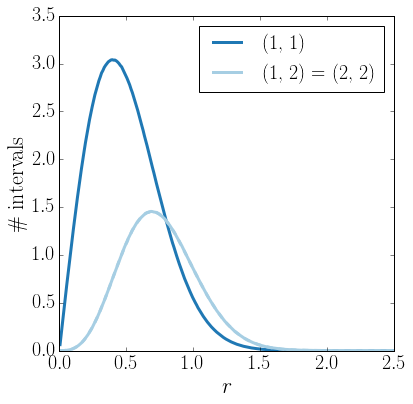

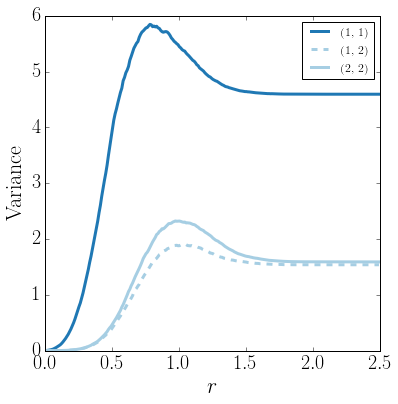

# intervals (Wrap complex)


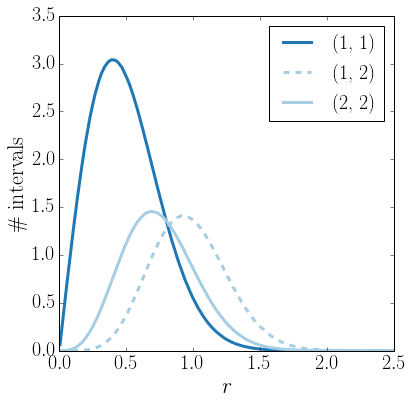

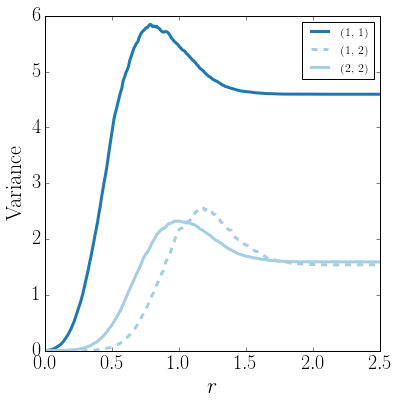

# critical simplices


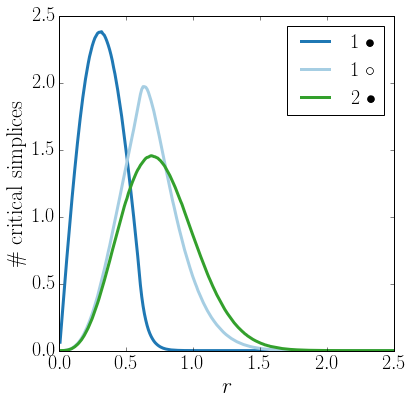

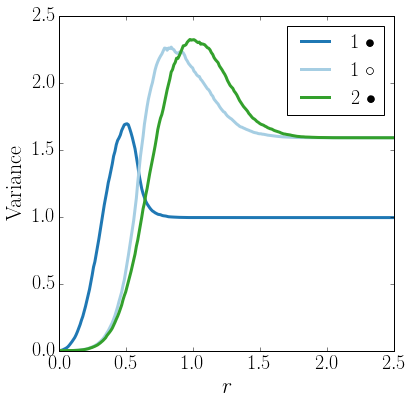

Betti numbers


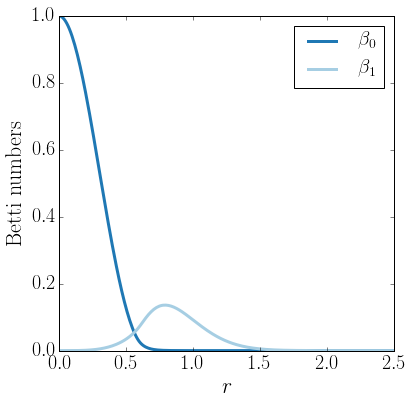

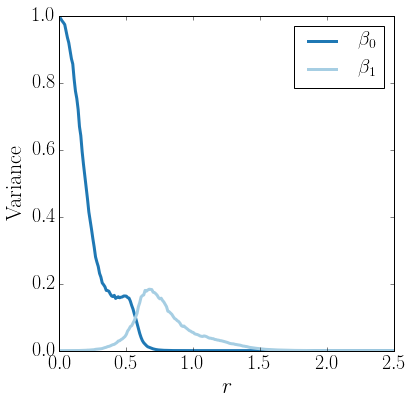

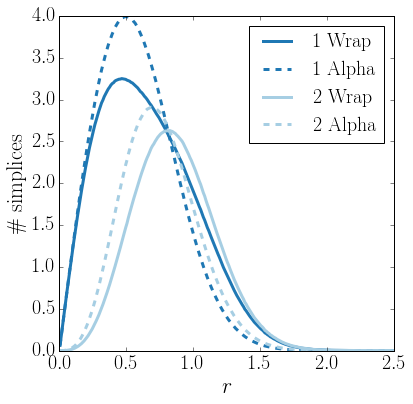

# simplices


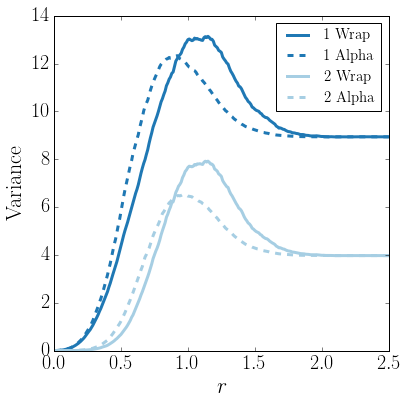

In [91]:
plt.rcParams['figure.figsize'] = (6,6) 

param2, title_list2, types_list2, means_list2, vars_pdf_list2, vars_cdf_list2, r_min2,r_max2,r_num2 = \
    load_densities(filename2a)
plot_densities_paper(filename2a, param2, title_list2, types_list2, means_list2, vars_pdf_list2, vars_cdf_list2, r_min2,r_max2,r_num2)  

../output/ppp_statistics_cluster/output2_2017-08-15_100_10000_p_densities.txt
# intervals (Delaunay complex)


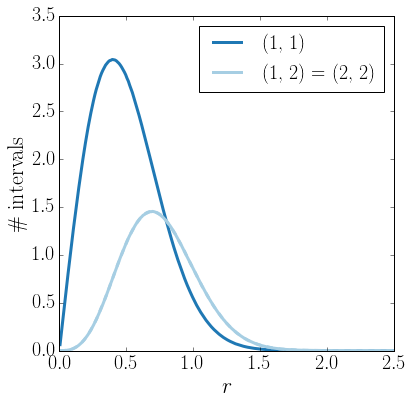

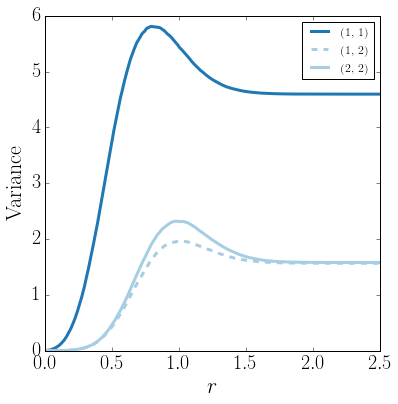

# intervals (Wrap complex)


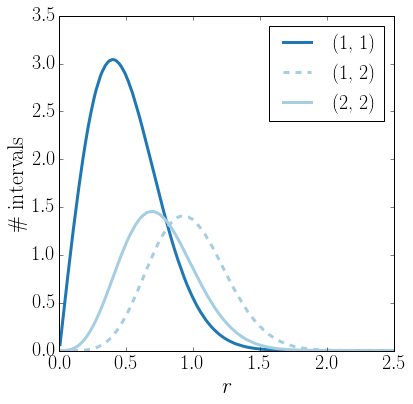

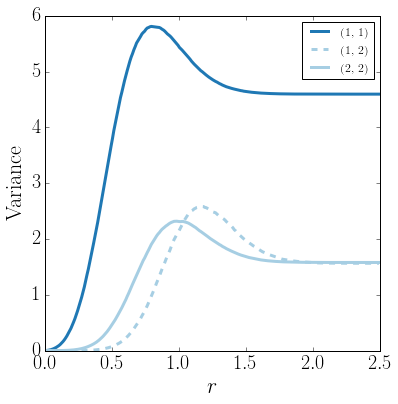

# critical simplices


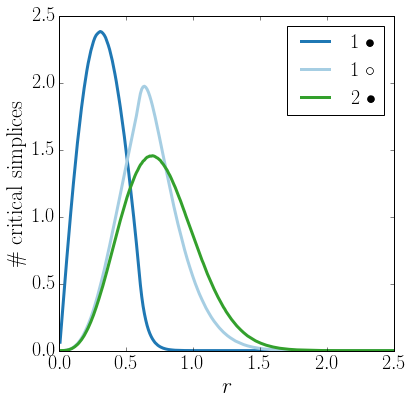

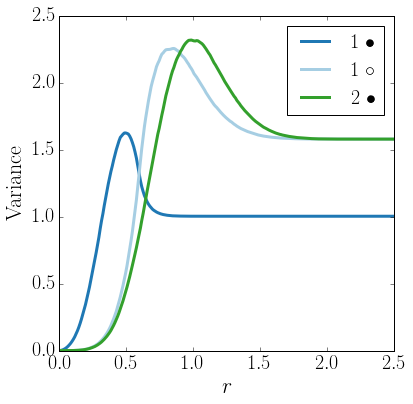

Betti numbers


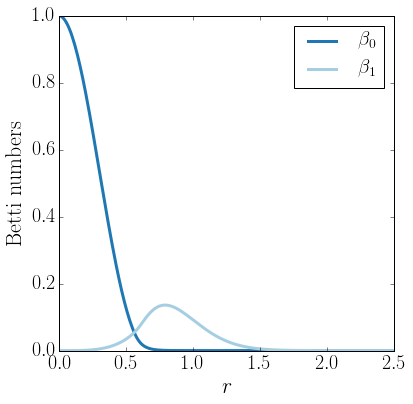

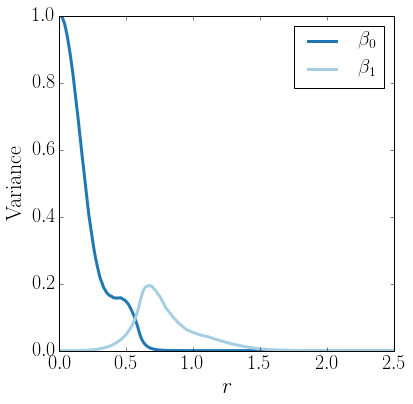

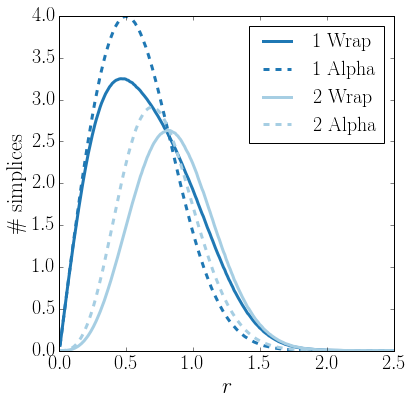

# simplices


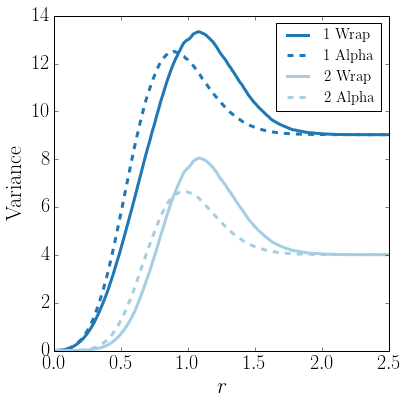

In [92]:
plt.rcParams['figure.figsize'] = (6,6) 
param, title_list, types_list, means_list, vars_pdf_list, vars_cdf_list, r_min,r_max,r_num = \
    load_densities(filename2b)
plot_densities_paper(filename2b, param, title_list, types_list, means_list, vars_pdf_list, vars_cdf_list, r_min,r_max,r_num)  

../output/ppp_statistics_cluster/output3_2017-09-08_60_100_p_multi_densities.txt
# intervals (Delaunay complex)


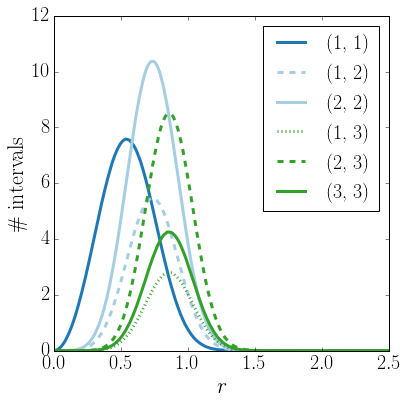

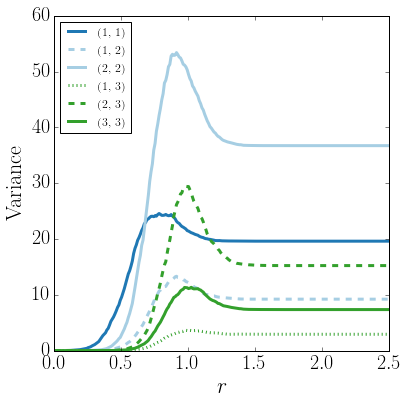

# intervals (Wrap complex)


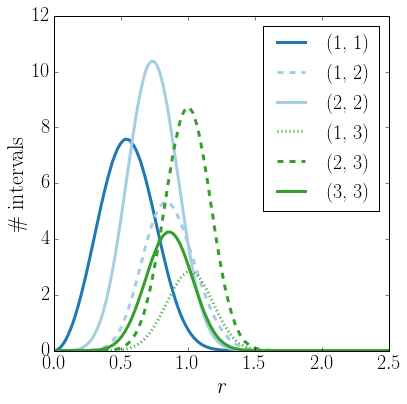

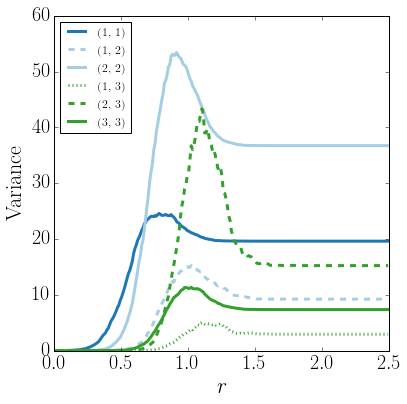

# critical simplices


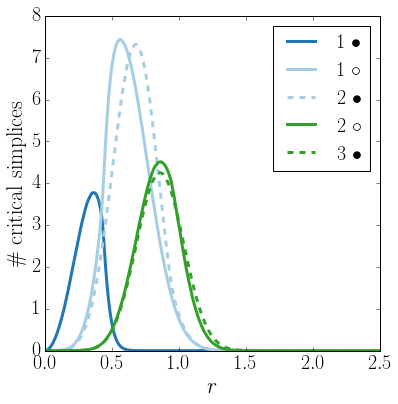

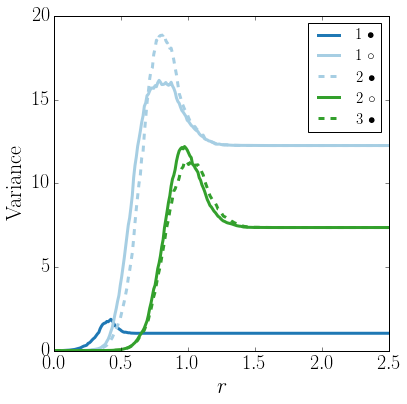

Betti numbers


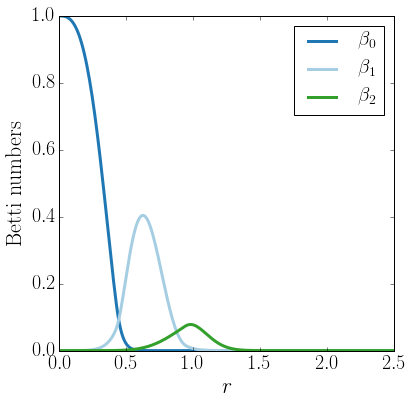

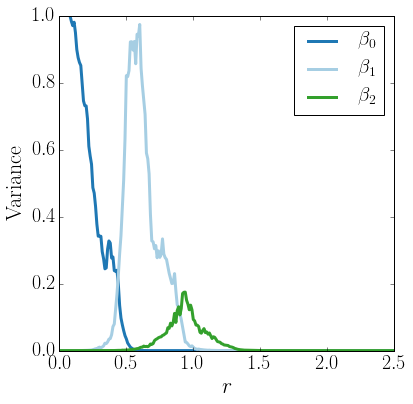

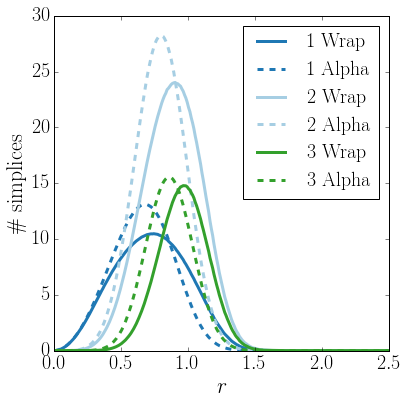

# simplices


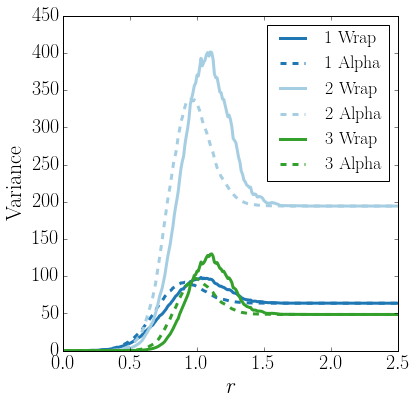

In [93]:
param3, title_list3, types_list3, means_list3, vars_pdf_list3, vars_cdf_list3, r_min3,r_max3,r_num3 = \
    load_densities(filename3a)
plot_densities_paper(filename3a, param3, title_list3, types_list3, means_list3, vars_pdf_list3, vars_cdf_list3, r_min3,r_max3,r_num3)  

../output/ppp_statistics_cluster/output3_2017-08-17_15_10000_p_densities.txt
# intervals (Delaunay complex)


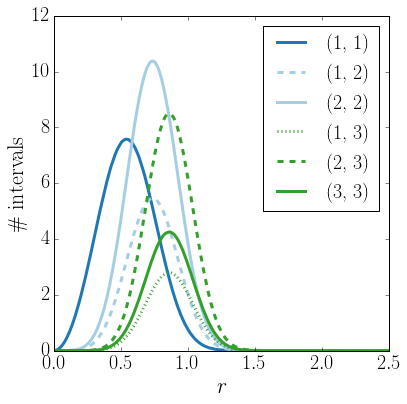

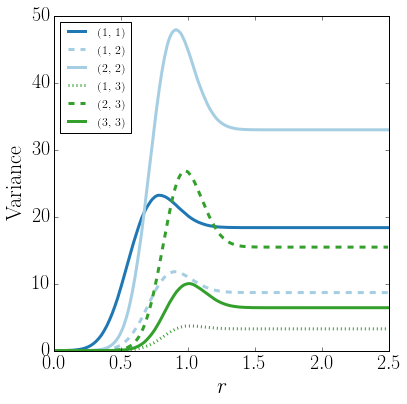

# intervals (Wrap complex)


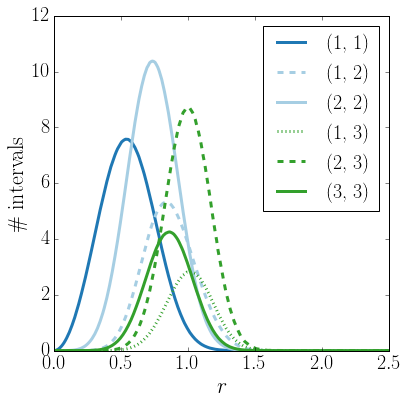

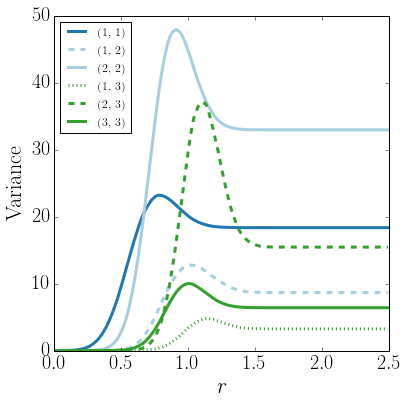

# critical simplices


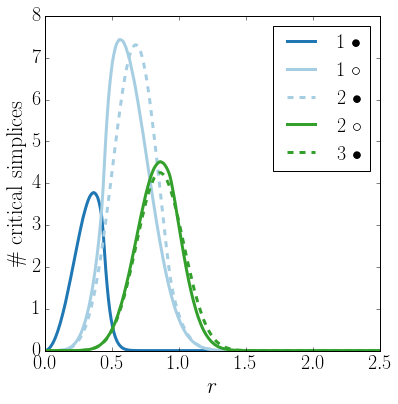

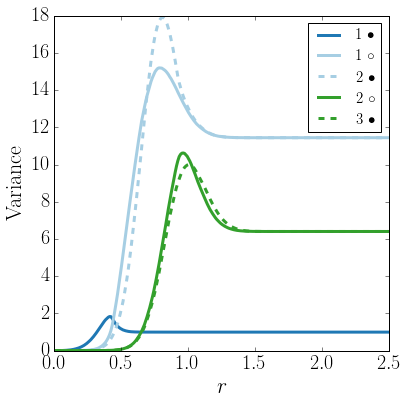

Betti numbers


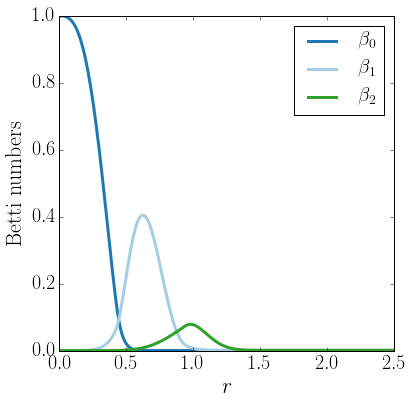

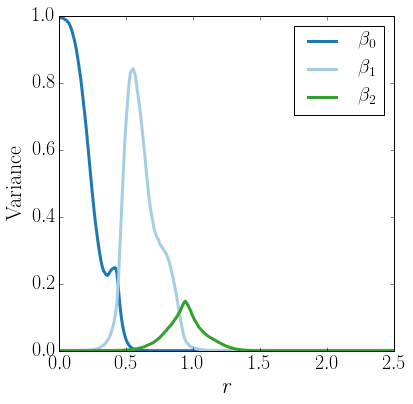

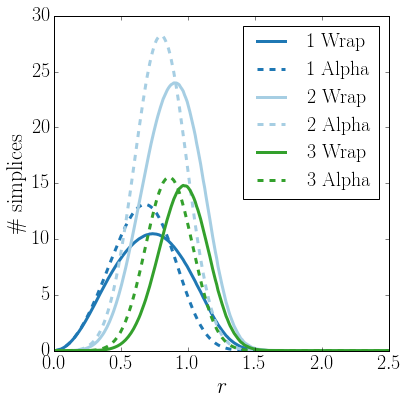

# simplices


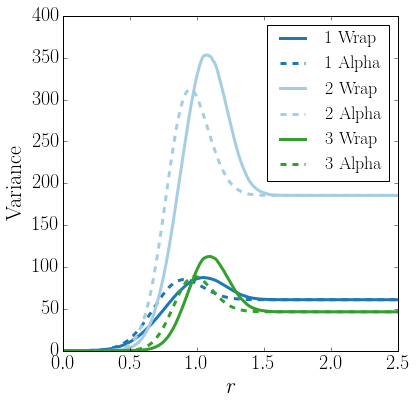

In [94]:
param, title_list, types_list, means_list, vars_pdf_list, vars_cdf_list, r_min,r_max,r_num = \
    load_densities(filename3b)
plot_densities_paper(filename3b, param, title_list, types_list, means_list, vars_pdf_list, vars_cdf_list, r_min,r_max,r_num)  

#### Theoretical results

In [18]:
from scipy.special import gammainc #gammainc(k,x) = 1/gamma(k) * integral(exp(-t) * t**(k-1), t=0..x)

def gamma(r,dim,k,b,c):
    """
    scaled lower incomplete Gamma function
    gamma(r,k,b,c)=c*((1/gamma(k))*int_{t=0}^{b*r^2} t^{k-1}e^{-t} dt)
    """
    return c*gammainc(k,b*r**dim)

def plot_theoretical_distr_intervals(dim, types_list, r_min, r_max, r_num):
    """
    plot densities of theoeritical distributions of intervals in Delaunay complex
    """
    #compute bins
    r_bins = np.linspace(r_min,r_max,r_num+1)
    r_bincenters = (r_bins[1:]+r_bins[:-1])*0.5
    rvalues = r_bins[1:]
    r_binsize = r_bins[1]-r_bins[0]
    
    if dim==3:
        ks = [1., 2., 3., 2., 3., 3.]
        bs = [4./3.*math.pi]*6
        cs = [4., 4.85, 1.85, 2.55, 3.7, 1.22]
    else:
        ks = [1., 2., 2.]
        bs = [math.pi]*3
        cs = [2., 1., 1.]
    
    
    if dim==3:
        int_order = [0,3,1,5,4,2]
        linestyles = ['-','--','-','--','-','--']
        colors = [colors7[a] for a in [0,0,1,1,2,2]]
    else:
        int_order = [0,2,1]
        linestyles = ['-']*3
        colors = colors7
        
    labels = ['('+str(typ).strip("[]")+')' for typ in types_list]    
    plt.figure()
    plt.ylabel('\# intervals', fontsize=30)
    plt.xlabel('r', fontsize=30)
    ax = plt.gca()
    ax.tick_params(axis='both', which='major', labelsize=20)
    for j,typ in enumerate(types_list): 
        jn = int_order[j]
        pdf = (gamma(r_bins[1:],dim,ks[jn],bs[jn],cs[jn])-gamma(r_bins[:-1],dim,ks[jn],bs[jn],cs[jn]))*1./r_binsize
        plt.plot(r_bincenters,np.array(pdf),color=colors[j],lw=3,\
                 label=labels[jn], linestyle = linestyles[j])  
    plt.legend(fontsize=20)
    plt.savefig(results_folder+'plot_theoretical_density_intervals_del_'+str(dim)+'.eps', bbox_inches='tight', format='eps', dpi=1000)
    plt.show()

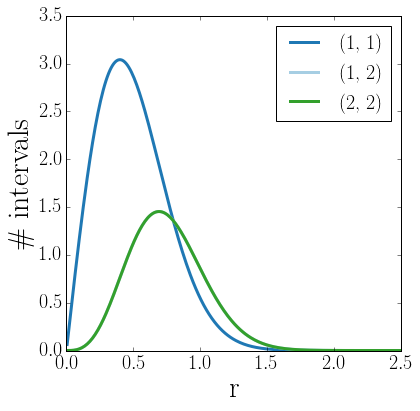

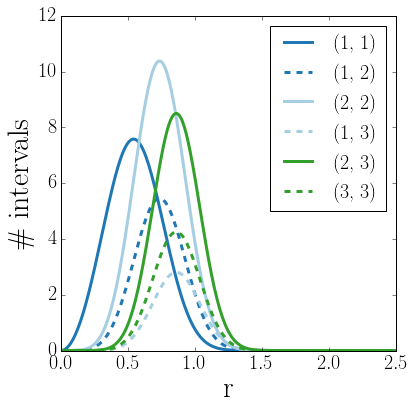

In [19]:
plt.rcParams['figure.figsize'] = (6,6) 
plot_theoretical_distr_intervals(2, types_list2[0], r_min2, r_max2, r_num2)
plot_theoretical_distr_intervals(3, types_list3[0], r_min3, r_max3, r_num3)

### Distribution of lowerset sizes

In [15]:
def load_lowerset_sizes(filename):
    """
    load distribution of lower set sizes
     input: * filename: of input data
     output: * param: dictionary containing parameter values 'dim', '# trials', 'window size', 'periodic', 'lambda'
             * distr_numsimp_mean: mean distribution of # simplices, integer bins [0,numsimp_max]
             * distr_diam_mean: mean distribution of diameters, bins np.linspace(0,diam_max,diam_nbins+1)
             * max_*_mean: maximum size, mean over trials
             * max_*_max: maximum size, max over trials
             * corr_*_r_mean: mean (over trials) correlation between lowerset size and filtration value r
             * percentiles_*_mean: mean (over trials) percentiles (for values in array percentiles) of distribution of lowerset sizes 
    """
    
    filename = os.path.splitext(filename)[0]+'_lowerset.txt'
    
    #load data
    param = {} #dictionary for general parameters
    data = [] #all data will be stored in this
    headers = [] #this array will store rows containing strings together with their row index
    load_data2(filename,data,headers,param)
    
    dim = param['dim']
    
    #initialize output arrays
    distr_numsimp_mean = []
    distr_diam_mean = []
    max_numsimp_mean = []
    max_diam_mean = []
    max_numsimp_max = []
    max_diam_max = []
    corr_numsimp_r_mean = []
    corr_diam_r_mean = []
    percentiles_numsimp_mean = []
    percentiles_diam_mean = []
    
    #read percentiles
    current_header_index = -1
    current_header_index = get_current_header_index(current_header_index,'percentiles',headers)
    percentiles = data[headers[current_header_index][0]+1]
    
    #types of singular intervals (dim, dim, pos?), disregarding pos/neg if len==2, all if == [0]
    if dim==3:
        types_lowersets = [[0],[1,1],[2,2],[3,3],[1,1,0],[1,1,1],[2,2,0],[2,2,1],[3,3,0]]
    else:
        types_lowersets = [[0],[1,1],[2,2],[1,1,0],[1,1,1],[2,2,0]]
    
    # simplices
    current_header_index = get_current_header_index(current_header_index,'# simplices',headers)
    numsimp_max = data[headers[current_header_index][0]+2][0]
    for typ in types_lowersets:
        current_header_index = get_current_header_index(current_header_index,'mean distribution over trials',headers)
        distr_numsimp_mean.append(data[headers[current_header_index][0]+1])
        current_header_index = get_current_header_index(current_header_index,'correlation',headers)
        corr_numsimp_r_mean.append(data[headers[current_header_index][0]+1][0])
        current_header_index = get_current_header_index(current_header_index,'percentiles over all trials',headers)
        if current_header_index is None:
            current_header_index = get_current_header_index(current_header_index,'mean percentiles',headers)
        percentiles_numsimp_mean.append(data[headers[current_header_index][0]+1])
        current_header_index = get_current_header_index(current_header_index,'max',headers)
        max_numsimp_mean.append(data[headers[current_header_index][0]+1][0])
        max_numsimp_max.append(data[headers[current_header_index][0]+1][1])
    # simplices
    current_header_index = get_current_header_index(current_header_index,'diameter',headers)
    diam_max = data[headers[current_header_index][0]+2][0]
    diam_nbins = data[headers[current_header_index][0]+2][1]
    for typ in types_lowersets:
        current_header_index = get_current_header_index(current_header_index,'mean distribution over trials',headers)
        distr_diam_mean.append(data[headers[current_header_index][0]+1])
        current_header_index = get_current_header_index(current_header_index,'correlation',headers)
        corr_diam_r_mean.append(data[headers[current_header_index][0]+1][0])
        current_header_index = get_current_header_index(current_header_index,'mean percentiles',headers)
        percentiles_diam_mean.append(data[headers[current_header_index][0]+1])
        current_header_index = get_current_header_index(current_header_index,'max',headers)
        max_diam_mean.append(data[headers[current_header_index][0]+1][0])
        max_diam_max.append(data[headers[current_header_index][0]+1][1])
        
    return param, types_lowersets, distr_numsimp_mean, distr_diam_mean, numsimp_max, diam_max, diam_nbins,\
        max_numsimp_mean, max_numsimp_max, max_diam_mean, max_diam_max, corr_numsimp_r_mean, corr_diam_r_mean,\
        percentiles, percentiles_numsimp_mean, percentiles_diam_mean

In [23]:
def print_lowerset_sizes(filename):
    #load data from file
    param, types_lowersets, distr_numsimp_mean, distr_diam_mean, numsimp_max, diam_max, diam_nbins,\
    max_numsimp_mean, max_numsimp_max, max_diam_mean, max_diam_max, corr_numsimp_r_mean, corr_diam_r_mean,\
    percentiles, percentiles_numsimp_mean, percentiles_diam_mean\
    =load_lowerset_sizes(filename)
    
    expected_num_points = param['lambda']*param['window size']**param['dim'] 
   
    print ''
    print '%-18s'%'maximum (max)'+''.join(['%-10s'%str(typ) for typ in types_lowersets])
    print '-------------------------------------------------------------------------------------------------------------'
    print '%-18s'%'# simplices'+''.join(['%-10.3f'%(max_numsimp_max[t]) for t in range(len(types_lowersets))])
    print '%-18s'%'diameter'+''.join(['%-10.3f'%(max_diam_max[t]) for t in range(len(types_lowersets))]) 
    
    print ''
    print '%-18s'%'maximum (avg)'+''.join(['%-10s'%str(typ) for typ in types_lowersets])
    print '-------------------------------------------------------------------------------------------------------------'
    print '%-18s'%'# simplices'+''.join(['%-10.3f'%(max_numsimp_mean[t]) for t in range(len(types_lowersets))])
    print '%-18s'%'diameter'+''.join(['%-10.3f'%(max_diam_mean[t]) for t in range(len(types_lowersets))]) 
   
    print ''
    print '%-18s'%'correlation'+''.join(['%-10s'%str(typ) for typ in types_lowersets])
    print '-------------------------------------------------------------------------------------------------------------'
    print '%-18s'%'r - # simplices'+''.join(['%-10.3f'%(corr_numsimp_r_mean[t]) for t in range(len(types_lowersets))])
    print '%-18s'%'r - diameter'+''.join(['%-10.3f'%(corr_diam_r_mean[t]) for t in range(len(types_lowersets))])
    
    print ''
    print 'percentiles over all trials'
    print ''
    print '# simpliecs'
    print '%-15s'%'percentiles'+''.join(['%-10s'%str(typ) for typ in types_lowersets])
    print '-------------------------------------------------------------------------------------------------------------'
    for i,perc in enumerate(percentiles):
        print '%-15s'%str(100-perc)+''.join(['%-10.2f'%(percentiles_numsimp_mean[t][i]) for t in range(len(types_lowersets))])
    
    print ''
    print 'diameter'
    print '%-15s'%'percentiles'+''.join(['%-10s'%str(typ) for typ in types_lowersets])
    print '-------------------------------------------------------------------------------------------------------------'
    for i,perc in enumerate(percentiles):
        print '%-15s'%str(100-perc)+''.join(['%-10.2f'%(percentiles_diam_mean[t][i]) for t in range(len(types_lowersets))])       

In [24]:
print_lowerset_sizes(filename2a)
print ''
print_lowerset_sizes(filename3a)

../output/ppp_statistics_cluster/output2_2017-08-15_300_1000_p_lowerset.txt

maximum (max)     [0]       [1, 1]    [2, 2]    [1, 1, 0] [1, 1, 1] [2, 2, 0] 
-------------------------------------------------------------------------------------------------------------
# simplices       93.000    1.000     93.000    1.000     1.000     85.000    
diameter          5.168     5.128     5.168     2.469     5.128     5.128     

maximum (avg)     [0]       [1, 1]    [2, 2]    [1, 1, 0] [1, 1, 1] [2, 2, 0] 
-------------------------------------------------------------------------------------------------------------
# simplices       60.959    1.000     60.959    1.000     1.000     60.592    
diameter          4.199     3.999     4.199     1.968     3.999     4.104     

correlation       [0]       [1, 1]    [2, 2]    [1, 1, 0] [1, 1, 1] [2, 2, 0] 
-------------------------------------------------------------------------------------------------------------
r - # simplices   0.492     nan       

### Fitting Curves

In [23]:
from scipy.optimize import curve_fit #Use non-linear least squares to fit a function, f, to data.
from scipy.special import gammainc #gammainc(k,x) = 1/gamma(k) * integral(exp(-t) * t**(k-1), t=0..x)

def gamma(r,dim,k,b,c):
    """
    scaled lower incomplete Gamma function
    gamma(r,k,b,c)=c*((1/gamma(k))*int_{t=0}^{b*r^2} t^{k-1}e^{-t} dt)
    """
    return c*gammainc(k,b*r**dim)

def multigamma(r,dim,num,ks,bs,cs):
    """
    linear combination of multiple lower incomplete Gamma functions
     input: * r: radius = alpha
            * num: number of Gamma functions
            * ks: list of 'k' paramters (length = num)
            * bs: list of 'b' paramters (length = num)
            * cs: list of 'c' paramters (length = num)
    multigamma(r,num,ks,bs,cs) = gamma(r,ks[0],bs[0],cs[0]) + gamma(r,ks[1],bs[1],cs[1])+
                                 ... + gamma(r,ks[num-1],bs[num-1],cs[num-1])
    """
    out = gamma(r,dim,ks[0],bs[0],cs[0])
    for i in range(1,num):
        out += gamma(r,dim,ks[i],bs[i],cs[i])
    return out
    
def multigamma_wrapper(r, dim, num, kfixed=None, bfixed=None, cfixed=None, *params):
    """
    wrapper for the multigamma function so that it can be used in curve_fit
    if kfixed, bfixed or cfixed != None: paramter(s) k, b or c are fixed to the given values
    """
    i=0
    if kfixed is None:
        ks = list(params[0][i*num:(i+1)*num])
        i += 1
    else:
        ks = kfixed
        
    if bfixed is None:
        bs = list(params[0][i*num:(i+1)*num])
        i += 1
    else:
        bs = bfixed
        
    if cfixed is None:
        cs = list(params[0][i*num:(i+1)*num])
    else:
        cs = cfixed
    return multigamma(r,dim,num,ks,bs,cs) 

def curvefit(dim,rvalues,datacurve,num_gammas,lowerbound=True,kfixed=None,bfixed=None,cfixed=None):
    """
    for a given datacurve (y-values) over a range of r-values (x-values) fit a combination of gamma functions
    num_gammas: number of gamma functions (each has 3 parameters)
    if lowerbound: only non-negative paramters allowed
    if kfixed, bfixed or cfixed != None: paramters k, b or c are fixed to the given values
    output: optimal parameter values ks, bs, cs (each is a list of length num_gammas) and least-squares error
    """
    if lowerbound:
        #only non-negative parameters allowed
        #bound=[0.,0.,0.]*num_gammas
        bound=[0.,0.,0.]*num_gammas #TEST TODO
    else:
        #no lower bound on c
        bound=[0.,0.,-np.inf]*num_gammas
   
    #fit a combination of gamma functions
    init = [1.]*3*num_gammas
    popt,_ = curve_fit((lambda r, *params: multigamma_wrapper(r,dim,num_gammas,kfixed,bfixed,cfixed,params)),\
                                   rvalues,datacurve,bounds=(bound,[np.inf]*3*num_gammas),p0=init,method='trf')                    
    #retrieve parametrs from popt, some of them might have been fixed and are not contained in the list
    i=0
    if kfixed is None:
        ks = list(popt[i*num_gammas:(i+1)*num_gammas])
        i += 1
    else:
        ks = kfixed
    if bfixed is None:
        bs = list(popt[i*num_gammas:(i+1)*num_gammas])
        i += 1
    else:
        bs = bfixed
    if cfixed is None:
        cs = list(popt[i*num_gammas:(i+1)*num_gammas])
    else:
        cs = cfixed   
    #compute least squares error (sum of squared deviations)
    error = np.sum((np.array([multigamma(r,dim,num_gammas,ks,bs,cs) for r in rvalues])-datacurve)**2)
    
    #repeat multiple times with higher initial guess for parameters
    """
    bestinit = 1
    for t in [2.,3.,4.]:
        try:
            init = [t]*3*num_gammas

            popt,_ = curve_fit((lambda r, *params: multigamma_wrapper(r,dim,num_gammas,kfixed,bfixed,cfixed,params)),\
                                       rvalues,datacurve,bounds=(bound,[np.inf]*3*num_gammas),p0=init,method='trf')                    
            #retrieve parametrs from popt, some of them might have been fixed and are not contained in the list
            i=0
            if kfixed is None:
                ks2 = list(popt[i*num_gammas:(i+1)*num_gammas])
                i += 1
            else:
                ks2 = kfixed
            if bfixed is None:
                bs2 = list(popt[i*num_gammas:(i+1)*num_gammas])
                i += 1
            else:
                bs2 = bfixed
            if cfixed is None:
                cs2 = list(popt[i*num_gammas:(i+1)*num_gammas])
            else:
                cs2 = cfixed   
            #compute least-squares error
            error2 = np.sum((np.array([multigamma(r,dim,num_gammas,ks2,bs2,cs2) for r in rvalues])-datacurve)**2)

            if error2 < error:
                bestinit = t
                ks = ks2; bs = bs2; cs = cs2; error = error2;
        except RuntimeError:
                pass
    print 'best initial guess: ',bestinit
    """
                  
    return ks,bs,cs,error

def plot_fit(ax,title,rvalues,datacurve,dim,num_gammas,ks,bs,cs,legend=False):
    """
    plot given datacurve together with its fitted curve
    if fitted curve is combination of gamma curves, also display the individual parts
    """
    ax.plot(rvalues,datacurve,lw=2,label='data curve')
                       
    ax.plot(rvalues,multigamma(rvalues,dim,num_gammas,ks,bs,cs),'r--', label='fitted curve',lw=2)
    
    if num_gammas>1:
        for i in range(num_gammas):
            ax.plot(rvalues,gamma(rvalues,dim,ks[i],bs[i],cs[i]),color='0.5')
                       
    ax.set_title('Fit of combination of '+str(num_gammas)+' gamma functions',fontsize=25)
    ax.set_xlabel('r',fontsize=30)
    ax.set_ylabel(title,fontsize=30)
    if(legend):
        ax.legend(loc='upper left',fontsize=20)


def plot_fit_curve(ax,title,rvalues,datacurve,fitted_curve):
    """
    plot given datacurve together with its fitted curve
    """
    ax.plot(rvalues,datacurve,label='data mean',lw=2)
    ax.plot(rvalues,fitted_curve,'r--', label='fitted curve',lw=2)
    ax.set_xlabel('r',fontsize=30)
    ax.set_ylabel(title,fontsize=30)


In [24]:
from scipy.stats import chisquare

def fit_meancurves(dim, nums_gammas, title_list, types_list, means_list, r_min, r_max, r_num, param,  kfixed=None, bfixed=None, cfixed=None):
    """
    fit mean curves of data over r-values to combinations of gamma functions 
     input: * title_list: titles of different types of data 
            * types_list: individual types of curves for each title
            * means_list: list of all mean curves, array of size len(title_list) x len(types_list) x num_bins
            * r_min, r_max, r_num => range of r-values = np.linspace(r_min,r_max,r_num+1)
            * param: dictionary containing parameter values 'dim', '# trials', 'window size', 'periodic', 'lambda'
            * k/b/cfixed: fix parameter k/b/c for curves whose titles are contained in this dictionary
     output: * fitted_parameters: array of all fitted parameters, len(title_list) x len(types_list) x len(num_gammas) x 3 x num_gammas
             * bestfit_numsgammas: for each title and type, numbers of gammas for 'best fit' (to be determined)
             * bestfit_errors: for each title and type, ls-error for 'best fit' (to be determined)
             * kstests: KS-test statistics
    """
    fitted_parameters = [] 
    bestfit_numsgammas = []
    bestfit_errors = []
    kstests = []
    
    dim=param['dim']
    expected_num_points = param['lambda']*param['window size']**dim 
    
    #compute bins
    r_bins = np.linspace(r_min,r_max,r_num+1)
    rvalues = (r_bins[1:]+r_bins[:-1])*0.5
    rvalues = r_bins[1:] #take upper bin limits for cdf!!
    
    #fit mean curves of #simplices to combination of 'num' gamma functions for 'num' in nums_gammas
    #iterate over titles
    for i,title in enumerate(title_list):
        
        fitted_parameters_title = []
        bestfit_numsgammas_title = []
        bestfit_errors_title = []
        kstests_title = []
        
        #iterate over different types for each title
        for t,typ in enumerate(types_list[i]):
            
            #get datacurve, divide by expected number of points, 'normalize'
            meancurve = np.array(np.cumsum(means_list[i][t]))*1./expected_num_points

            #initialize arrays
            parameters = [[]]*len(nums_gammas)
            errors = np.zeros(len(nums_gammas)) 
            significances = np.zeros(len(nums_gammas)) 
            redchi2s = np.zeros(len(nums_gammas)) 
            lowerbounds_c = [False]*len(nums_gammas)
            bestfit_error = 1.
            bestfit_numgammas = 1
            kstest = np.zeros(len(nums_gammas))
            #fig = plt.figure()

            title_new = title.replace('#','\#')

            #fit combination of num_gammas = 1,2,... gamma functions
            for j,num_gammas in enumerate(nums_gammas):

                #curve-fitting, least-squares error
                #try with and without lower bounds (=0) on c, only allow negative c if error diminishes at list by factor of 10
                err = -1;
                ks=[0]*num_gammas
                bs=[0]*num_gammas
                cs=[0]*num_gammas
                #try: 
                #    ks_nb,bs_nb,cs_nb,err_nb = curvefit(dim,rvalues,meancurve,num_gammas,lowerbound=False)
                #except RuntimeError:
                #    pass
                try: 
                    ks,bs,cs,err = curvefit(dim,rvalues,meancurve,num_gammas,lowerbound=True) 
                except RuntimeError:
                    pass
                """
                if err_nb == -1:
                    if err_b == -1:
                        err = -1;
                    else:
                        err = err_b;
                        ks = ks_b; bs = bs_b; cs = cs_b;
                        lowerbounds_c[j] = True;
                else:
                    if (err_b == -1 or  err_b*1.01 > err_nb): #only use lower bound for c if necessary
                        err = err_nb;
                        ks = ks_nb; bs = bs_nb; cs = cs_nb;
                    else: 
                        err = err_b;
                        ks = ks_b; bs = bs_b; cs = cs_b;
                        lowerbounds_c[j] = True;
                """

                #save fitted parameters and error
                parameters[j]=[ks,bs,cs]
                errors[j]=err/(1.*len(rvalues))

                #statistical significance ~ BIC
                num_param=3*num_gammas*1.
                num_samples=len(rvalues)*1.
                bic = num_param*np.log(num_samples)+num_samples*np.log(err/num_samples)
                significances[j] = bic

                redchi2 = np.sum((np.array([multigamma(r,dim,num_gammas,ks,bs,cs) for r in rvalues])/np.sum(cs)-meancurve/np.max(meancurve))**2)
                redchi2s[j] = redchi2/(num_samples-num_param)
                #chi2s[j], pvals[j] = chisquare(np.array([multigamma(r,dim,num_gammas,ks,bs,cs) for r in alphas]),f_exp=meancurve,ddof=3*num_gammas)

                #KS-Test: compute largest deviation of cdfs
                kstest[j] = np.max(np.abs(np.array([multigamma(r,dim,num_gammas,ks,bs,cs) for r in rvalues])/np.sum(cs)-meancurve/np.max(meancurve)))
                
                #save 'best fit', only allow more gamma functions if error diminishes at least by factor of 10 TODO
                if err>0 and err<bestfit_error/10.:
                    bestfit_error=err
                    bestfit_numgammas=num_gammas

                #plot
                #ax=fig.add_subplot(1,len(nums_gammas),j+1)
                #plot_fit(ax,title_new,rvalues,meancurve,dim,num_gammas,ks,bs,cs)

            fitted_parameters_title.append(parameters)
            bestfit_errors_title.append(bestfit_error/(1.*len(rvalues)))
            bestfit_numsgammas_title.append(bestfit_numgammas)
            kstests_title.append(kstest)
            
            print title
            print ' type', typ 
            for j,num_gammas in enumerate(nums_gammas):
                #print 'combination of %d:                     MS-error: %.2E  kstest: %.2E   BIC: %f   redchi2: %.2E'%(num_gammas,errors[j],kstest[j],significances[j],redchi2s[j])
                print 'combination of %d:                     MS-error: %.2E  L2-error: %.2E'%(num_gammas,errors[j],math.sqrt(abs(errors[j])))

                if(errors[j]<0):
                    print ' (fitting failed)'
                #if(lowerbounds_c[j]):
                #    print ' (lower bound for c used)'

                for n in range(num_gammas):
                    print '  k%d = %.3f,  b%d = %.3f,  c%d = %.3f'%(n+1,fitted_parameters_title[t][j][0][n],n+1,\
                                                            fitted_parameters_title[t][j][1][n],n+1,fitted_parameters_title[t][j][2][n])
            #plt.show()
            
        fitted_parameters.append(fitted_parameters_title)
        bestfit_errors.append(bestfit_errors_title)
        bestfit_numsgammas.append(bestfit_numsgammas_title)
        kstests.append(kstests_title)

    return fitted_parameters, bestfit_numsgammas, bestfit_errors, kstests

In [25]:
def print_bestfit_errors(dim,title_list,types_list,bestfit_numsgammas,bestfit_errors):
    print 'dim = %d'%dim
    for i,title in enumerate(title_list[:-1]):
        print title
        print '%-25s %-10s %-10s'%('typ        ','# gammas', 'L2-difference')
        print '---------------------------------------------'
        for j,typ in enumerate(types_list[i]):
            print '%-25s %-10i %-.2E'%(typ, bestfit_numsgammas[i][j], math.sqrt(bestfit_errors[i][j]))

In [26]:
def show_bestfits(dim,title_list,types_list,param,means_list,fitted_parameters,bestfit_numsgammas,bestfit_errors,r_min,r_max,r_num):
    #compute bins
    r_bins = np.linspace(r_min,r_max,r_num+1)
    rvalues = r_bins[1:]

    for i,title in enumerate(title_list[:-1]):
        figrowwidth = len(types_list[i])
        tworows = False
        if len(types_list[i])>4:
            figrowwidth = int(math.ceil(len(types_list[i])/2.))
            tworows = True
        plt.rcParams['figure.figsize'] = (9*figrowwidth,7*(1+tworows))
        expected_num_points = param['lambda']*param['window size']**dim
        fig = plt.figure()
        for j,typ in enumerate(types_list[i]):
            if not tworows:
                ax = fig.add_subplot(1,figrowwidth,j+1)
            else:
                ax = fig.add_subplot(2,figrowwidth,j+1)
            meancurve = np.cumsum(np.array(means_list[i][j]))*1./expected_num_points
            ks,bs,cs = fitted_parameters[i][j][nums_gammas.index(bestfit_numsgammas[i][j])]
            title_new = title.replace('#','\#')
            plot_fit(ax,title_new+'\ntyp = '+str(typ).strip('[]'),rvalues,meancurve,dim,bestfit_numsgammas[i][j],ks,bs,cs,legend=True)
            text=r'\noindent combination of %d: ~ L2-error: %.2E\\ \\'%(bestfit_numsgammas[i][j],math.sqrt(bestfit_errors[i][j]))                 
            for n in range(bestfit_numsgammas[i][j]):
                text=text+r'  $k_%d = %.2f,  b_%d = %.2f,  c_%d = %.2f$\\ \\'%(n+1,ks[n],n+1,bs[n],n+1,cs[n])
            ax.tick_params(axis='both', which='major', labelsize=20)
            ax.tick_params(axis='both', which='major', labelsize=20)
            ax.set_title(text,fontsize=30)  
            plt.tight_layout(pad=1)
    plt.tight_layout(pad=1)
    plt.show()

In [27]:
nums_gammas = [1,2,3]
plt.rcParams['figure.figsize'] = (9*len(nums_gammas),7)
fitted_parameters2, bestfit_numsgammas2, bestfit_errors2, kstests2 = fit_meancurves(2, nums_gammas, title_list2[:-1], types_list2, means_list2, r_min2, r_max2, r_num2, param2,  kfixed=None, bfixed=None, cfixed=None)

# intervals (Delaunay complex)
 type [1, 1]
combination of 1:                     MS-error: 1.88E-10  L2-error: 1.37E-05
  k1 = 1.000,  b1 = 3.142,  c1 = 2.000
combination of 2:                     MS-error: 1.48E-10  L2-error: 1.21E-05
  k1 = 2.756,  b1 = 5.874,  c1 = 0.000
  k2 = 1.000,  b2 = 3.142,  c2 = 2.000
combination of 3:                     MS-error: 1.61E-10  L2-error: 1.27E-05
  k1 = 1.008,  b1 = 3.147,  c1 = 1.130
  k2 = 0.990,  b2 = 3.136,  c2 = 0.870
  k3 = 0.887,  b3 = 2.482,  c3 = 0.000
# intervals (Delaunay complex)
 type [2, 2]
combination of 1:                     MS-error: 2.29E-10  L2-error: 1.51E-05
  k1 = 2.000,  b1 = 3.142,  c1 = 1.000
combination of 2:                     MS-error: 1.31E-10  L2-error: 1.14E-05
  k1 = 1.963,  b1 = 3.098,  c1 = 0.479
  k2 = 2.035,  b2 = 3.184,  c2 = 0.521
combination of 3:                     MS-error: -4.00E-03  L2-error: 6.32E-02
 (fitting failed)
  k1 = 0.000,  b1 = 0.000,  c1 = 0.000
  k2 = 0.000,  b2 = 0.000,  c2 = 0.000
  

C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:100: RuntimeWarning: invalid value encountered in log
C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:103: RuntimeWarning: invalid value encountered in divide
C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:108: RuntimeWarning: invalid value encountered in divide


dim = 2
# intervals (Delaunay complex)
typ                       # gammas   L2-difference
---------------------------------------------
[1, 1]                    1          1.37E-05
[2, 2]                    1          1.51E-05
[1, 2]                    1          1.33E-05
# intervals (Wrap complex)
typ                       # gammas   L2-difference
---------------------------------------------
[1, 1]                    1          1.37E-05
[2, 2]                    1          1.51E-05
[1, 2]                    2          2.41E-05
# critical simplices
typ                       # gammas   L2-difference
---------------------------------------------
[1, 1, 0]                 3          1.45E-03
[1, 1, 1]                 2          4.54E-04
[2, 2, 0]                 1          1.53E-05
# simplices (Delaunay complex)
typ                       # gammas   L2-difference
---------------------------------------------
[1]                       2          1.71E-05
[2]                       1       

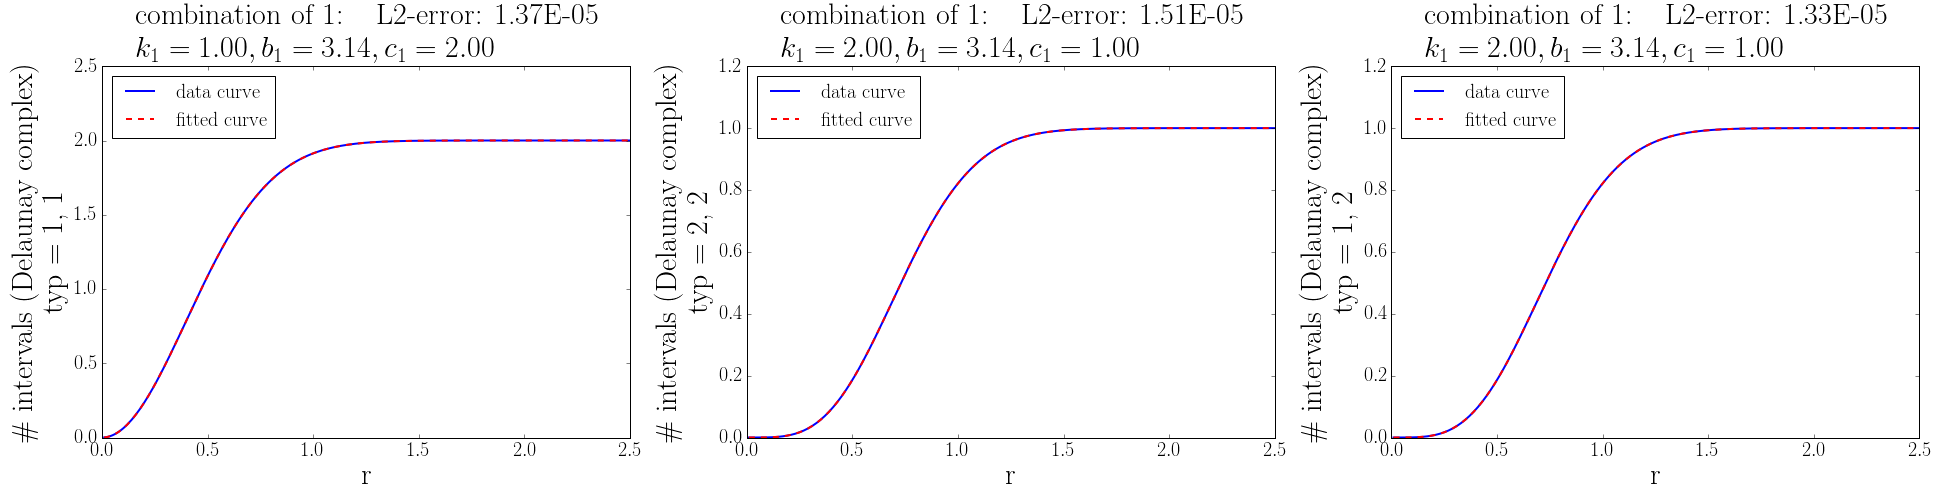

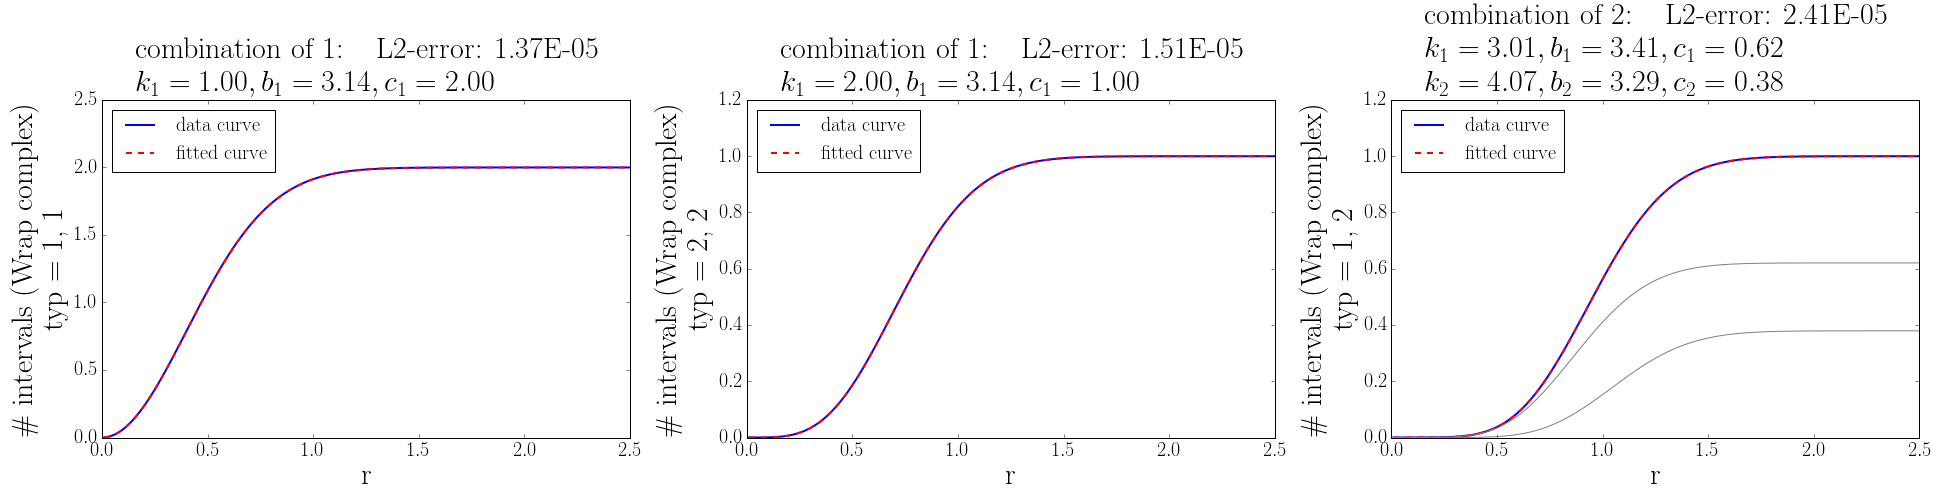

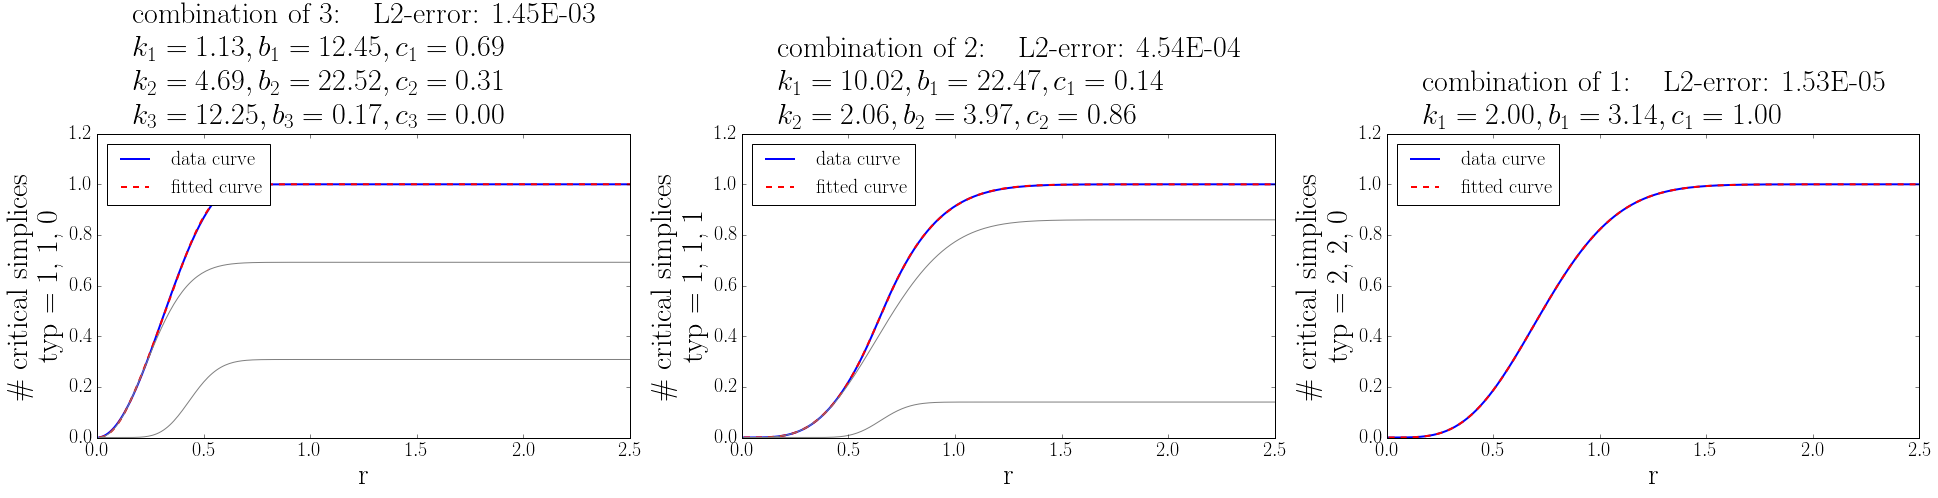

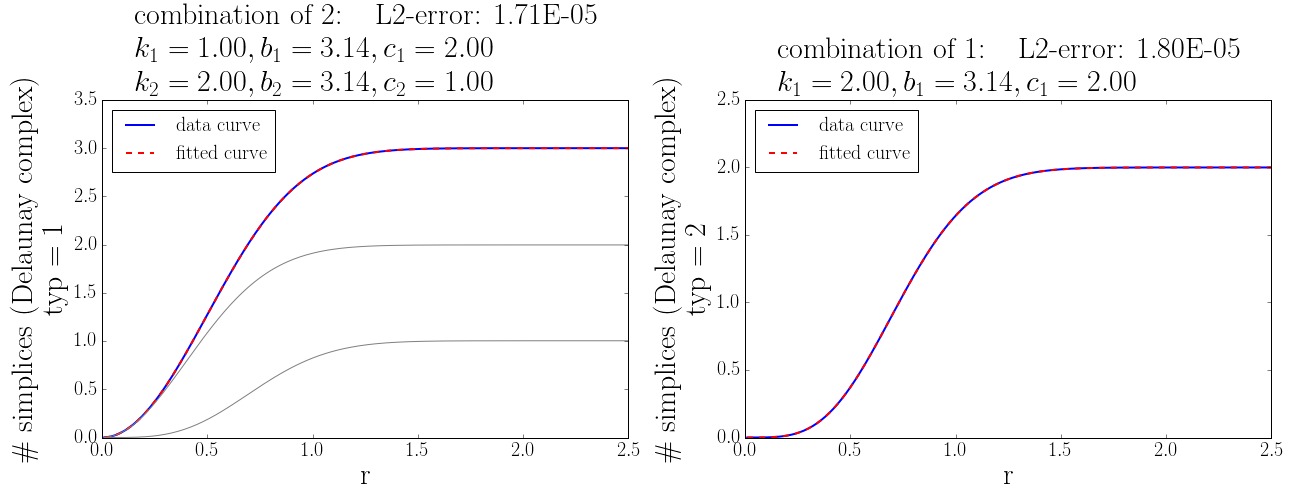

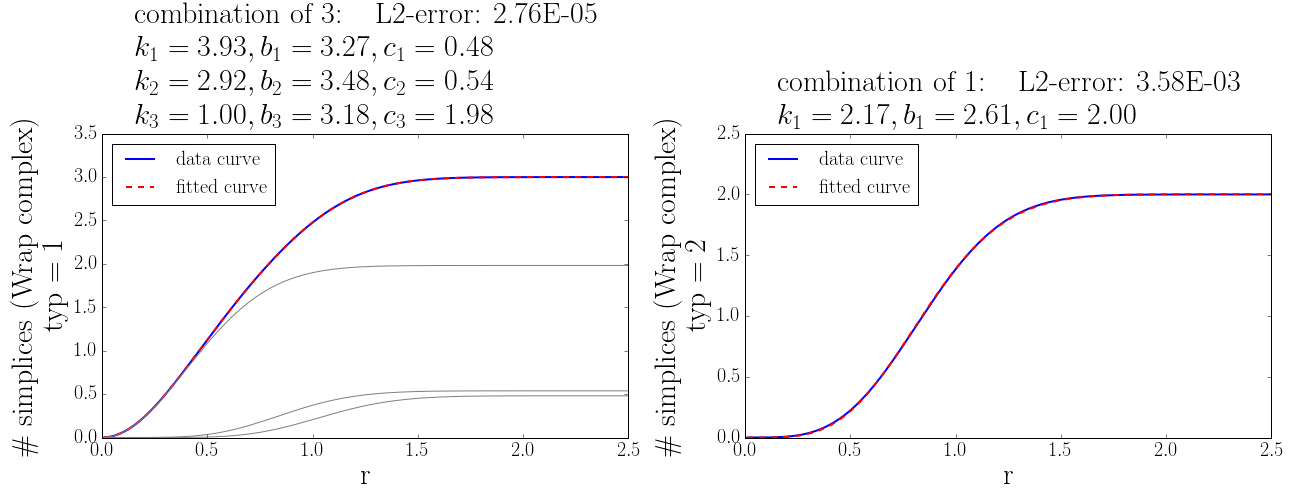

In [28]:
print_bestfit_errors(2,title_list2,types_list2,bestfit_numsgammas2,bestfit_errors2)
show_bestfits(2,title_list2,types_list2,param2,means_list2,fitted_parameters2,bestfit_numsgammas2,bestfit_errors2,r_min2,r_max2,r_num2)

In [29]:
fitted_parameters3, bestfit_numsgammas3, bestfit_errors3, kstests3 = fit_meancurves(3, nums_gammas, title_list3[:-1], types_list3, means_list3, r_min3, r_max3, r_num3, param3,  kfixed=None, bfixed=None, cfixed=None)

# intervals (Delaunay complex)
 type [1, 1]
combination of 1:                     MS-error: 4.85E-09  L2-error: 6.96E-05
  k1 = 1.000,  b1 = 4.188,  c1 = 3.999
combination of 2:                     MS-error: 4.47E-09  L2-error: 6.69E-05
  k1 = 0.990,  b1 = 4.182,  c1 = 2.320
  k2 = 1.015,  b2 = 4.197,  c2 = 1.679
combination of 3:                     MS-error: 4.48E-09  L2-error: 6.69E-05
  k1 = 0.987,  b1 = 4.180,  c1 = 1.850
  k2 = 1.012,  b2 = 4.195,  c2 = 2.149
  k3 = 0.803,  b3 = 8.436,  c3 = 0.000
# intervals (Delaunay complex)
 type [2, 2]
combination of 1:                     MS-error: 4.46E-09  L2-error: 6.68E-05
  k1 = 2.001,  b1 = 4.190,  c1 = 4.849
combination of 2:                     MS-error: 2.71E-09  L2-error: 5.20E-05
  k1 = 1.971,  b1 = 4.142,  c1 = 2.828
  k2 = 2.044,  b2 = 4.259,  c2 = 2.021
combination of 3:                     MS-error: -4.00E-03  L2-error: 6.32E-02
 (fitting failed)
  k1 = 0.000,  b1 = 0.000,  c1 = 0.000
  k2 = 0.000,  b2 = 0.000,  c2 = 0.000
  

C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:100: RuntimeWarning: invalid value encountered in log
C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:103: RuntimeWarning: invalid value encountered in divide
C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:108: RuntimeWarning: invalid value encountered in divide


dim = 3
# intervals (Delaunay complex)
typ                       # gammas   L2-difference
---------------------------------------------
[1, 1]                    1          6.96E-05
[2, 2]                    1          6.68E-05
[3, 3]                    1          3.13E-05
[1, 2]                    1          4.01E-05
[2, 3]                    1          5.50E-05
[1, 3]                    1          3.23E-05
# intervals (Wrap complex)
typ                       # gammas   L2-difference
---------------------------------------------
[1, 1]                    1          6.96E-05
[2, 2]                    1          6.68E-05
[3, 3]                    1          3.13E-05
[1, 2]                    2          7.52E-05
[2, 3]                    2          1.51E-04
[1, 3]                    2          6.89E-05
# critical simplices
typ                       # gammas   L2-difference
---------------------------------------------
[1, 1, 0]                 3          1.68E-04
[1, 1, 1]               

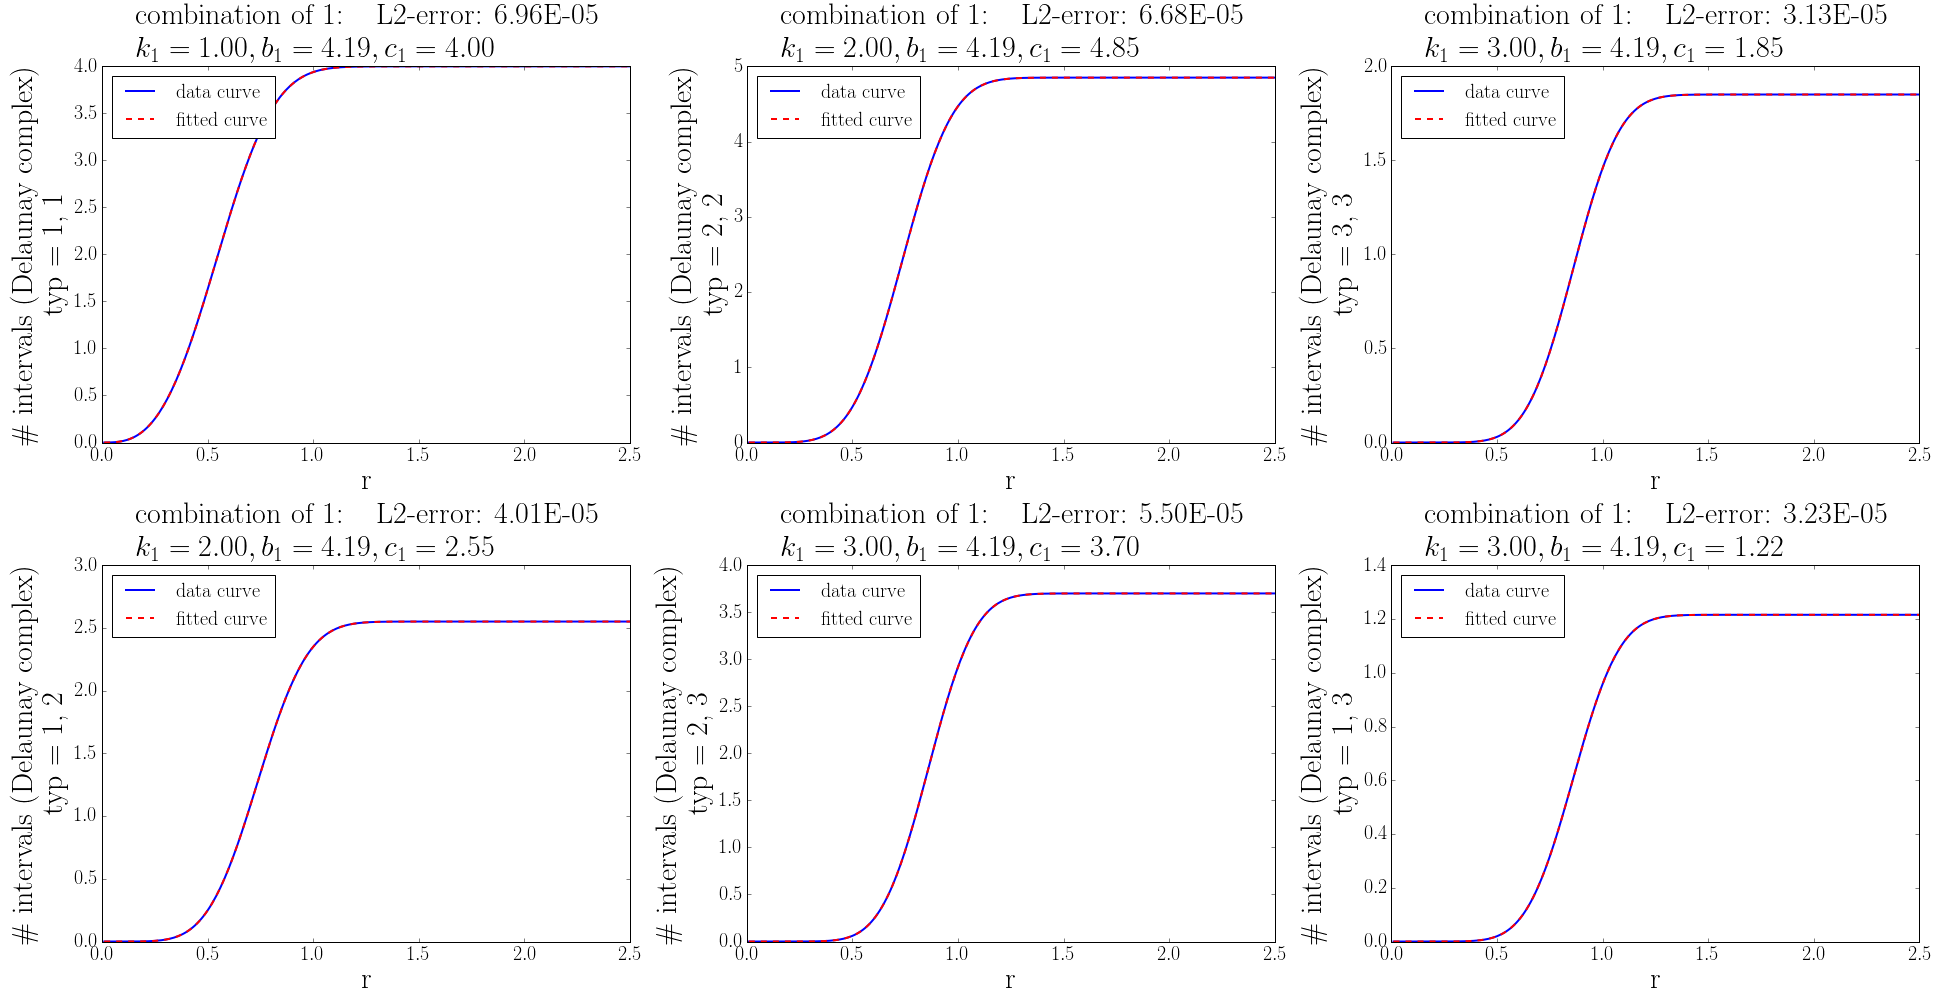

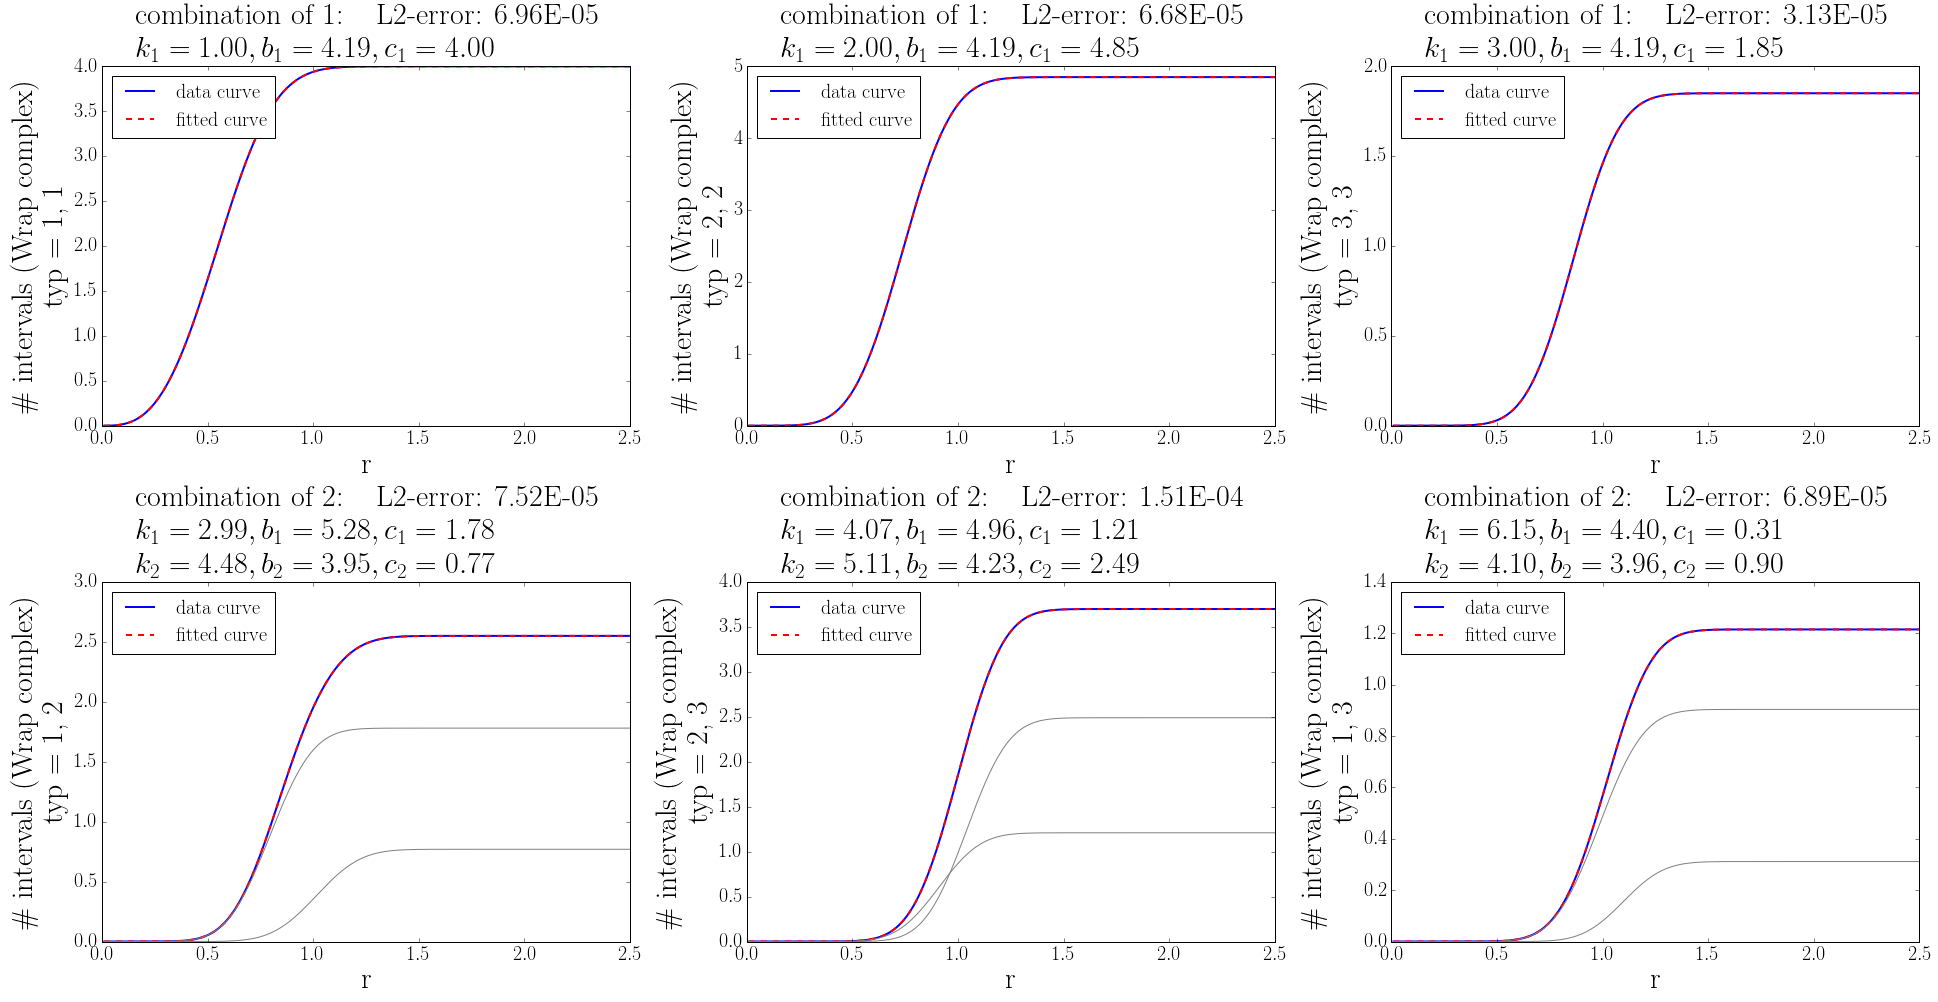

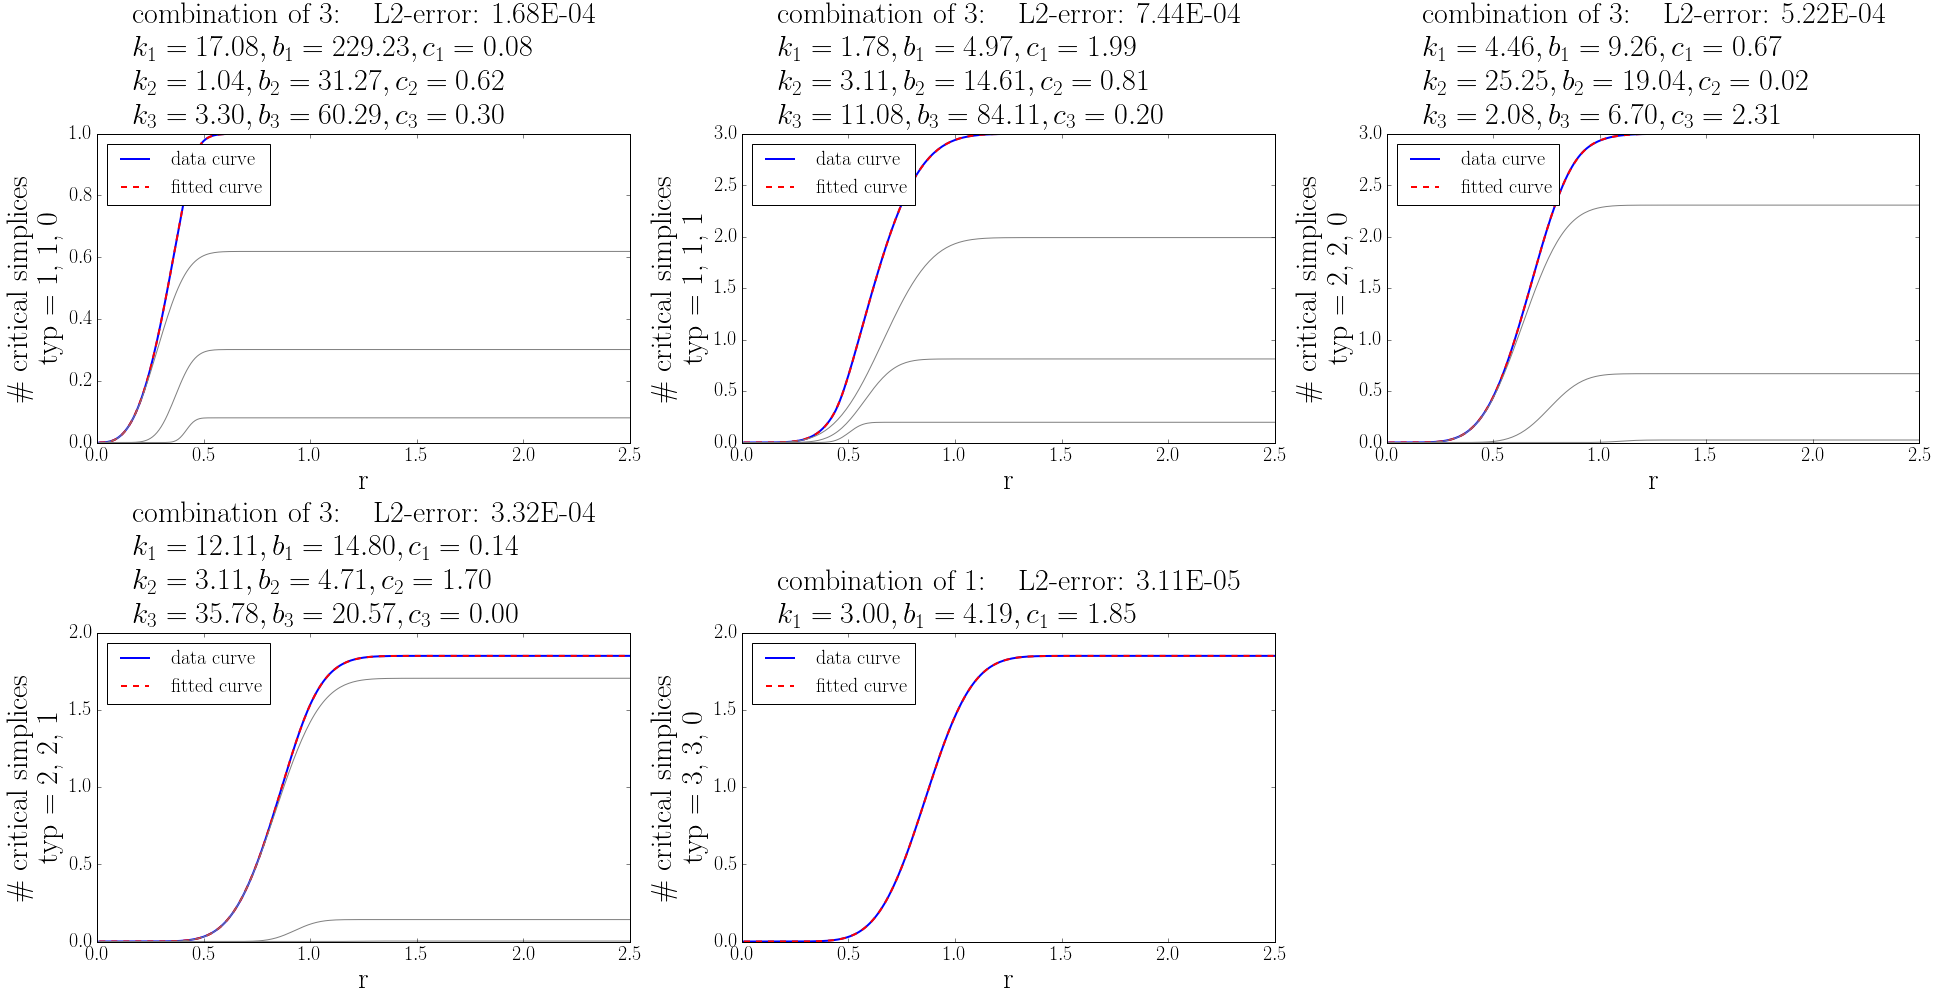

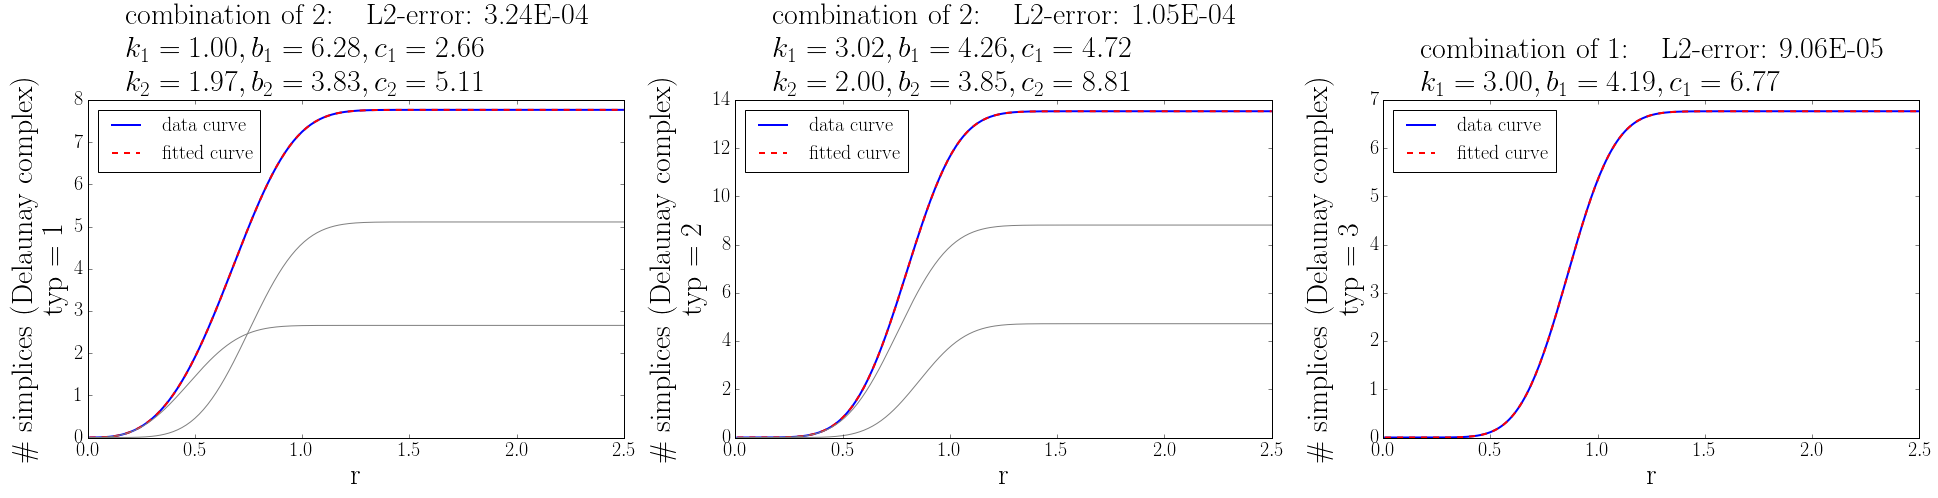

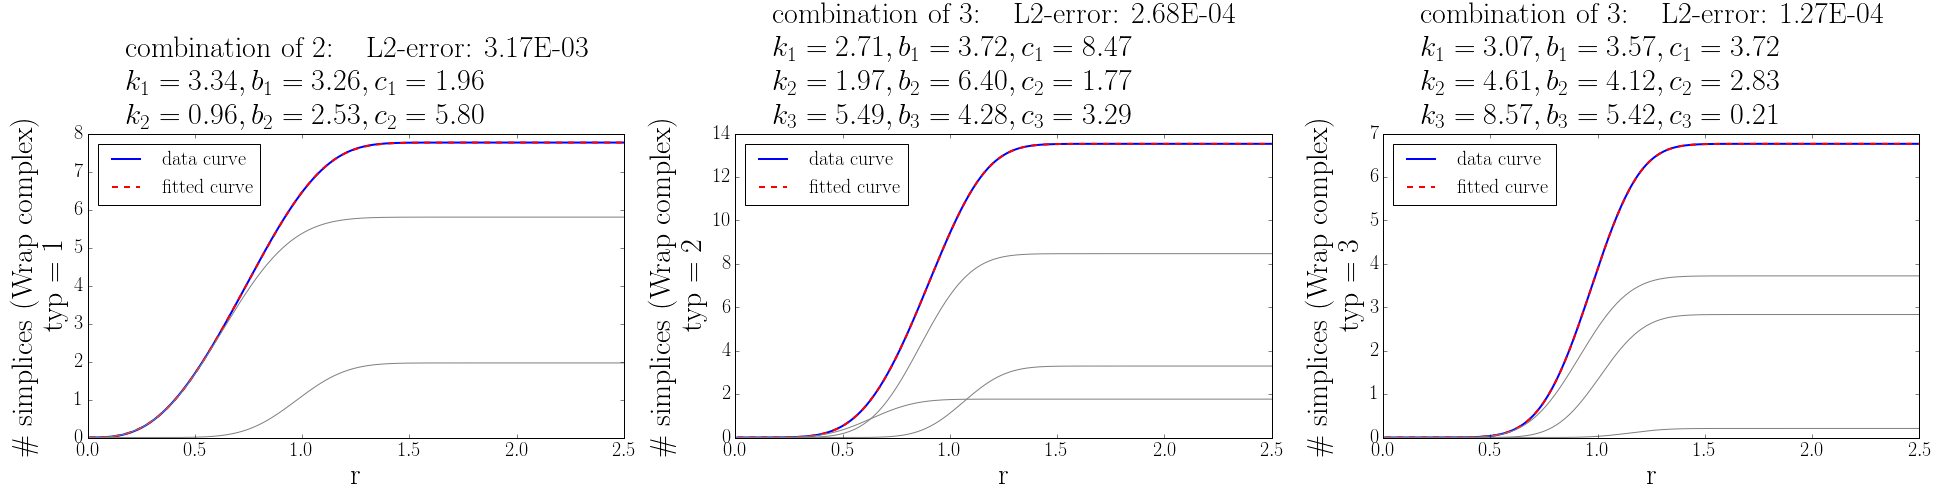

In [30]:
print_bestfit_errors(3,title_list3,types_list3,bestfit_numsgammas3,bestfit_errors3)
show_bestfits(3,title_list3,types_list3,param3,means_list3,fitted_parameters3,bestfit_numsgammas3,bestfit_errors3,r_min3,r_max3,r_num3)

# 3. Examples for Hole Manipulations

* start interactive software with './wrap_2_3'

* load data: 'Input->Load points'
    * 2D: 'data_mytests/flower1.txt'
    * 3D: 'data_pdb/gramicidin_1nt5_coords_noweights.txt'
    
* adapt view 'View->Redraw'
    * 2D: Point size 2, Line width 3
    * 3D: Point size 4, Line width 3
        * side view: Rotate scene x 1 y -98 z 0, Rotate light source x -158 y 132 z 0, scale 0.0168337
        * top view: Rotate scene x 94 y 6 z 14, Rotate light source x -114 y 74 z 0, scale 0.0168337
    
* select subcomplex: use checkboxes for 'Alpha' or 'Wrap', use slider to choose r-value

* apply hole manipulating operations 'Operation->Hole operation'
    * choose 'full' or 'subcomplex' for first or second approach
    * choose dimension, type of operation
    * choose targeted persistence pair (ordered by decreasing persistence)
    * disable 'Highlight'
    * 'Apply'
    * 'Undo all' before applying next operation

* export image of complex 'View->Export PNG-image' or 'View->Export SVG-image'
  
* export image of persistence diagram 'View->Export persistence diagram'

# 4. Statistics for Hole Manipulations

 produce data with: './wrap_2_3 statistics_hole_operations [dim] [window_size] [lambda] [num_trials] [periodic?] [draw?]'

In [28]:
def read_data_holeyII_paper(filename, singletrial = False):
    """
    for every trial, read the relevant statistics
        from the data file, put into vectors
    output: 
    * results_alltrials ... list of vectors (length = # trials) for all the statistics
    * titles ... corresponding titles
    """
    
    data = [] #all data will be stored in this
    load_data1(filename,data)
    
    

    current_index = -1;

    param = {} #dictionary for parameters
    if not singletrial:
        #read parameters
        current_index = get_next_row_starting_with(current_index,'# trials',data)+1;
        param['# trials']=data[current_index][0];
        param['dim']=data[current_index][1];
        param['window size']=data[current_index][2];
        param['lambda']=data[current_index][3];
        param['periodic']=data[current_index][4];
    else:
        param['# trials']=1

    titles = []
    values = []
    trial = -1
    
    if singletrial:
        trial = 0
        current_index+=1
    
    current_index += 1;
    title_counter = 0;
    while current_index<len(data):
        if len(data[current_index])>=2:
            if data[current_index][0]=="TRIAL":
                #new trial
                trial += 1;
                title_counter = -1;
            else:
                title_counter += 1;
                if trial == 0:
                    #first trial
                    titles.append(data[current_index][0]);
                    if len(data[current_index])==2:
                        values.append([data[current_index][1]]);
                    else:
                        values.append([[data[current_index][i] for i in range(1,len(data[current_index]))]]);
                else:
                    #later trial
                    if len(data[current_index])==2:
                        values[title_counter].append(data[current_index][1]);
                    else:
                        values[title_counter].append([data[current_index][i] for i in range(1,len(data[current_index]))]);
                        
        current_index +=1;

    print 'Read data from %d trials.'%(trial+1)
    return values, titles

In [24]:
def print_statistics_hole_manipulations(filename,singletrial=False):
    results_alltrials, titles = read_data_holeyII_paper(filename,singletrial)
    print 'Results for %d trials:'%len(results_alltrials[0])
    print '------------------------------'
    title_prefix_old='prefix'
    for i in range(len(titles)):
        if not 'additions_per' in titles[i] and not 'max' in titles[i] and (not 'total' in titles[i] or titles[i]=='dimall_num_all_dependences_total'):
            title_prefix = (titles[i].split('_'))[0]
            if title_prefix not in {'co','dim-1'}:
                if title_prefix != title_prefix_old:
                    print ''
                    title_prefix_old = title_prefix
                if('density' in titles[i]):
                    print ' %-42s %.3f \t+- %f'%(titles[i]+':',np.mean(results_alltrials[i])*100,np.std(results_alltrials[i]))
                else:
                    print ' %-42s %.1f \t+- %f'%(titles[i]+':',np.mean(results_alltrials[i]),np.std(results_alltrials[i]))

In [19]:
filename5 = '../output/holeyII_statistiscs/output3_2018-11-30_5_100.txt'
print_statistics_hole_manipulations(filename5)

Read data from 100 trials.
Results for 100 trials:
------------------------------

 num_vertices:                              124.1 	+- 9.805769
 num_edges:                                 817.7 	+- 72.112975
 num_triangles:                             1357.6 	+- 124.372889
 num_tetrahedra:                            663.1 	+- 61.999142
 num_simplices:                             2963.5 	+- 268.030204

 standard_density_R:                        0.061 	+- 0.000054
 standard_density_U:                        0.203 	+- 0.000153
 standard_density_C:                        0.118 	+- 0.000094
 standard_density_Q:                        0.093 	+- 0.000080
 standard_density_V:                        0.203 	+- 0.000152
 standard_density_D:                        0.142 	+- 0.000108

 exhaustive_density_R:                      0.159 	+- 0.000122
 exhaustive_density_U:                      0.336 	+- 0.000266
 exhaustive_density_C:                      0.076 	+- 0.000065
 exhaustive_density_Q:   

In [18]:
filename8 = '../output/holeyII_statistiscs/output3_2018-11-30_8_100.txt'
print_statistics_hole_manipulations(filename8)

Read data from 100 trials.
Results for 100 trials:
------------------------------

 num_vertices:                              510.8 	+- 20.493902
 num_edges:                                 3699.5 	+- 153.559595
 num_triangles:                             6323.5 	+- 264.949522
 num_tetrahedra:                            3133.9 	+- 131.743844
 num_simplices:                             13668.7 	+- 570.427773

 standard_density_R:                        0.014 	+- 0.000005
 standard_density_U:                        0.065 	+- 0.000035
 standard_density_C:                        0.032 	+- 0.000014
 standard_density_Q:                        0.022 	+- 0.000010
 standard_density_V:                        0.065 	+- 0.000036
 standard_density_D:                        0.043 	+- 0.000020

 exhaustive_density_R:                      0.046 	+- 0.000021
 exhaustive_density_U:                      0.124 	+- 0.000085
 exhaustive_density_C:                      0.018 	+- 0.000008
 exhaustive_density

In [14]:
filename10 = '../output/holeyII_statistiscs/output3_2018-12-03_10_100.txt'
print_statistics_hole_manipulations(filename10)

Read data from 100 trials.
Results for 100 trials:
------------------------------

 num_vertices:                              998.4 	+- 34.852351
 num_edges:                                 7397.6 	+- 265.594193
 num_triangles:                             12730.7 	+- 462.287934
 num_tetrahedra:                            6330.5 	+- 231.321832
 num_simplices:                             27458.3 	+- 993.653970

 standard_density_R:                        0.007 	+- 0.000002
 standard_density_U:                        0.039 	+- 0.000019
 standard_density_C:                        0.017 	+- 0.000006
 standard_density_Q:                        0.011 	+- 0.000005
 standard_density_V:                        0.039 	+- 0.000019
 standard_density_D:                        0.024 	+- 0.000010

 exhaustive_density_R:                      0.026 	+- 0.000011
 exhaustive_density_U:                      0.078 	+- 0.000052
 exhaustive_density_C:                      0.009 	+- 0.000004
 exhaustive_densit

In [29]:
filenameG = '../output/holeyII_statistiscs/output3_2018-12-04_gramicidin_1nt5_coords_noweights.txt'
print_statistics_hole_manipulations(filenameG, singletrial=True)

Read data from 1 trials.
Results for 1 trials:
------------------------------

 num_vertices:                              560.0 	+- 0.000000
 num_edges:                                 4172.0 	+- 0.000000
 num_triangles:                             7182.0 	+- 0.000000
 num_tetrahedra:                            3569.0 	+- 0.000000
 num_simplices:                             15484.0 	+- 0.000000

 standard_density_R:                        0.012 	+- 0.000000
 standard_density_U:                        0.049 	+- 0.000000
 standard_density_C:                        0.027 	+- 0.000000
 standard_density_Q:                        0.020 	+- 0.000000
 standard_density_V:                        0.049 	+- 0.000000
 standard_density_D:                        0.037 	+- 0.000000

 exhaustive_density_R:                      0.040 	+- 0.000000
 exhaustive_density_U:                      0.112 	+- 0.000000
 exhaustive_density_C:                      0.016 	+- 0.000000
 exhaustive_density_Q:          

# 5. Bregman-Voronoi diagrams

In [5]:
# generate random points, store, load
def generateRandomPoints(n,filename=None,domain_size=1.):
    points = np.random.rand(n,2)*domain_size
    if filename is not None:
        np.savetxt(filename,points,delimiter=" ")
    return points

def loadPoints(filename):
    return np.loadtxt(filename,delimiter=" ")

In [62]:
#generate random points, store
generateRandomPoints(100,filename="../output/bregman_paper/approximate_voronoi/thesis/points.txt",domain_size=2.);

In [6]:
def dist2(point1,point2,typ="Euclidean",domain="Square"):
    point1 = np.array(point1)
    point2 = np.array(point2)
    if typ == "Euclidean":
        return np.sum((point1-point2)*(point1-point2))
    elif typ == "KL_primal":
        return np.sum((point1*np.log(point1)-point1*np.log(point2)-point1+point2))
    elif typ == "KL_dual":
        return np.sum((point2*np.log(point2)-point2*np.log(point1)-point2+point1))
    elif typ == "Fisher":
        #transform x->sqrt(2x)
        point1 = np.sqrt(2.*point1)
        point2 = np.sqrt(2.*point2)
        if domain=="Square":
            return np.sum((point1-point2)*(point1-point2))
        else: #standard simplex
            return 2.*(math.acos(np.sum(point1*point2)/2.))^2;
    elif typ == "KLweightedEuclidean_primal":
        weight1 = 0.5*np.sum(point1*point1)-(np.sum(point1*np.log(point1)-point1))
        return np.sum((point1-point2)*(point1-point2))-weight1
    else:
        return -1
    
def simplex2plane(x,y,z):
    return np.array([y+0.5*z,math.sqrt(3)/2.*z])

def plane2simplex(u,v):
    z = 2./math.sqrt(3)*v
    y = u-v/math.sqrt(3)
    eps=1e-12
    return np.array([max(eps,1-y-z),max(eps,y),max(eps,z)])

In [7]:
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
def approximate_voronoi(points,discretization,typ="Euclidean",domain="Square",outputfile=""):
    if domain=="Square":
        pixel_borders = np.linspace(0,2,discretization+1)
        pixel_centers_x = np.array((pixel_borders[1:]+pixel_borders[:-1])/2.)
        pixel_centers_y = pixel_centers_x
    else:
        plane_points = np.array([simplex2plane(point[0],point[1],point[2]) for point in points])
        pixel_borders_x = np.linspace(0,1,discretization+1)
        pixel_centers_x = np.array((pixel_borders_x[1:]+pixel_borders_x[:-1])/2.)
        pixel_borders_y = np.linspace(0,math.sqrt(3)/2.,int(discretization*math.sqrt(3)/2.)+1)
        pixel_centers_y =  np.array((pixel_borders_y[1:]+pixel_borders_y[:-1])/2.)
    voronoi_labels = np.zeros((len(pixel_centers_x),len(pixel_centers_y)))
    border_values = {}
    border_tolerance = 0.05
    for xi,x in enumerate(pixel_centers_x):
        for yi,y in enumerate(pixel_centers_y):
            if domain=="Square" or (y<=math.sqrt(3)*x and y<=math.sqrt(3)*(1.-x)):
                best_dist = -1.
                best_labels = []
                borderpoint = False
                bordervalue = -1
                
                for i,point in enumerate(points):
                    if domain=="Square":
                        dist = dist2(point,[x,y],typ)
                    else:
                        dist = dist2(point,plane2simplex(x,y),typ)
                    if(abs(dist-best_dist)<best_dist*border_tolerance):
                        borderpoint = True
                        bordervalue = (dist+best_dist)/2.
                        best_labels.append(i)
                    if(dist<best_dist or best_dist<0):
                        best_dist = dist
                        best_labels = [i]
                        borderpoint = False
                voronoi_labels[xi,yi]=best_labels[0]
                if borderpoint:
                    best_labels.sort()
                    key = " ".join(map(str, best_labels))
                    if key in border_values:
                        border_values[key]=border_values[key]+[bordervalue]
                    else:
                        border_values[key]=[bordervalue]
    if outputfile!="":
        f = open(outputfile+"_labels.txt",'w') 
        for line in voronoi_labels:
            f.write(", ".join(map(str,map(int,(line)))))
            f.write("\n")
        f2 = open(outputfile+"_bordervalues.txt",'w') 
        for key in border_values:
            f2.write(key+", ")
            f2.write(str(min(border_values[key])))
            f2.write(", ")
            f2.write(str(max(border_values[key])))
            f2.write("\n")              

    return np.array(voronoi_labels), border_values

In [8]:
def draw_approximate_voronoi(filename,directory,discretization,voronoi_labels,domain="Square",ax=None,title="",zoom=1.,print_extra = True, circumcenters_file = "",circumcenter_labels=False,circumcenter_size=100,typ="",export=False,green=False):
    points = loadPoints(directory+filename+'.txt')
    
    for i in range(len(voronoi_labels)):
        for j in range(len(voronoi_labels[i])):
            if voronoi_labels[i][j]<0:
                voronoi_labels[i][j]=len(points)
    
    # modify color map to have black and white as extreme values
    if not green:
        cmap_values = mpl.cm.gist_ncar(np.arange(256)) #128 for green-blue color map
        for i in range(3):
            #cmap_values[255,i] = 0. #127 for green-blue color map
            cmap_values[0,i] = 1.
        my_cmap = mpl.colors.ListedColormap(cmap_values, name='myColorMap', N=cmap_values.shape[0])
        
    else:
        cmap_values = mpl.cm.gist_ncar(np.arange(128)) #128 for green-blue color map
        for i in range(3):
            #cmap_values[127,i] = 0. #127 for green-blue color map
            cmap_values[0,i] = 1.
        my_cmap = mpl.colors.ListedColormap(cmap_values, name='myColorMap', N=cmap_values.shape[0])
    
    if ax is None:
        ax = plt.gca()
        
    if domain=="Square":
        ax.imshow((voronoi_labels.T), cmap=my_cmap, interpolation='nearest',extent=[0,2,0,2],origin="Lower")
        ax.scatter(points[:,0],points[:,1],c=(np.array(range(len(points)))),cmap=my_cmap)
        ax.set_xlim(0,2/zoom)
        ax.set_ylim(0,2/zoom)
    else:
        ax.imshow((voronoi_labels.T), cmap=my_cmap, interpolation='nearest',extent=[0,1,0,math.sqrt(3)/2],origin="Lower") 
        plane_points = np.array([simplex2plane(point[0],point[1],point[2]) for point in points])
        ax.scatter(plane_points[:,0],plane_points[:,1],c=range(len(points)),cmap=my_cmap)  
        ax.set_xlim(0,1/zoom)
        ax.set_ylim(0,math.sqrt(3)/2/zoom)
    if title!="":
        ax.set_title(title.replace('_','\_'),fontsize=30)
    ax.tick_params(axis='both', which='major', labelsize=20)
    
    if(export):
        plt.figure()
        plt.imshow((voronoi_labels.T), cmap=my_cmap, interpolation='nearest',extent=[0,2,0,2],origin="Lower")
        plt.scatter(points[:,0],points[:,1],s=200,c="k")
        plt.xlim(0,2/zoom)
        plt.ylim(0,2/zoom)
        plt.axis('off')
        outputfile=directory+filename+"_"+str(discretization)+"_"+typ+"_image.eps"
        plt.savefig(outputfile, bbox_inches='tight', format='eps', dpi=300)
        
    #draw circumcenters that we computed on top, check if they agree with approximate Voronoi vertices
    if circumcenters_file != "":
        try: 
            centerfile = open(circumcenters_file, 'r')
            datareader = csv.reader(centerfile, delimiter = ',')
            next(datareader) #skiprow
            simplex_indices = []
            simplex_vertices = []
            circumcenters = []
            count_nan = 0
            count_outside = 0
            for row in datareader:
                simplex_indices.append(row[0])
                simplex_vertices.append(row[1])
                circumcenters.append(map(float,row[2].strip().split(" ")))
            simplex_vertices = np.array(simplex_vertices)
            draw_centers = np.array(circumcenters)
            if typ == "Fisher":
                draw_centers = np.array([np.power(point,2.)/2. for point in draw_centers])
            if(domain!="Square"):
                draw_centers = np.array([simplex2plane(point[0],point[1],point[2]) for point in draw_centers])
            ax.scatter(draw_centers[:,0],draw_centers[:,1],c='black',s=circumcenter_size)
            for i, [x, y] in enumerate(draw_centers):
                if min(x,y)<=0:
                    count_nan = count_nan+1
                    if print_extra:
                         print "nan", simplex_indices[i], simplex_vertices[i], [x,y]
                elif max(x,y)<2/zoom+0.1:
                    if(circumcenter_labels):
                        ax.text(x+0.01, y+0.01, str(simplex_vertices[i]), fontsize=12)
                else: 
                    count_outside = count_outside+1
                    if print_extra:
                        print simplex_indices[i], simplex_vertices[i], [x,y]
            print '# NaN', count_nan, ' # outside', count_outside
            if domain=="Square":
                ax.set_xlim(-0.1,2/zoom+0.1)
                ax.set_ylim(-0.1,2/zoom+0.1)
        except getattr(__builtins__,'FileNotFoundError', IOError):
            0

In [9]:
def compute_all_approximate_voronoi(filename,directory,discretization=100,domain="Square"):
    points = loadPoints(directory+filename+'.txt')
    for typ in ["Euclidean","KL_primal","KL_dual","Fisher"]:            
        approximate_voronoi(points,discretization,typ,domain,directory+filename+"_"+str(discretization)+"_"+typ)

In [10]:
def draw_all_approximate_voronoi(filename,directory,discretization,domain="Square",zoom=1.,export=False,green=False):
    fig, ax = plt.subplots(2,2)
    for i,typ in enumerate(["KL_primal","KL_dual","Fisher","Euclidean"]):
        voronoi_labels = np.loadtxt(directory+filename+"_"+str(discretization)+"_"+typ+"_labels.txt",delimiter = ',')
        draw_approximate_voronoi(filename,directory,discretization,voronoi_labels,domain,ax[i/2][i%2],typ=typ,zoom=zoom,export=export,green=green)

In [11]:
directory = "../output/bregman_paper/approximate_voronoi/thesis/"
filename = "uniform_points2_2_100"

In [66]:
#it is faster to run .py-file from command line
compute_all_approximate_voronoi(filename,directory,50)

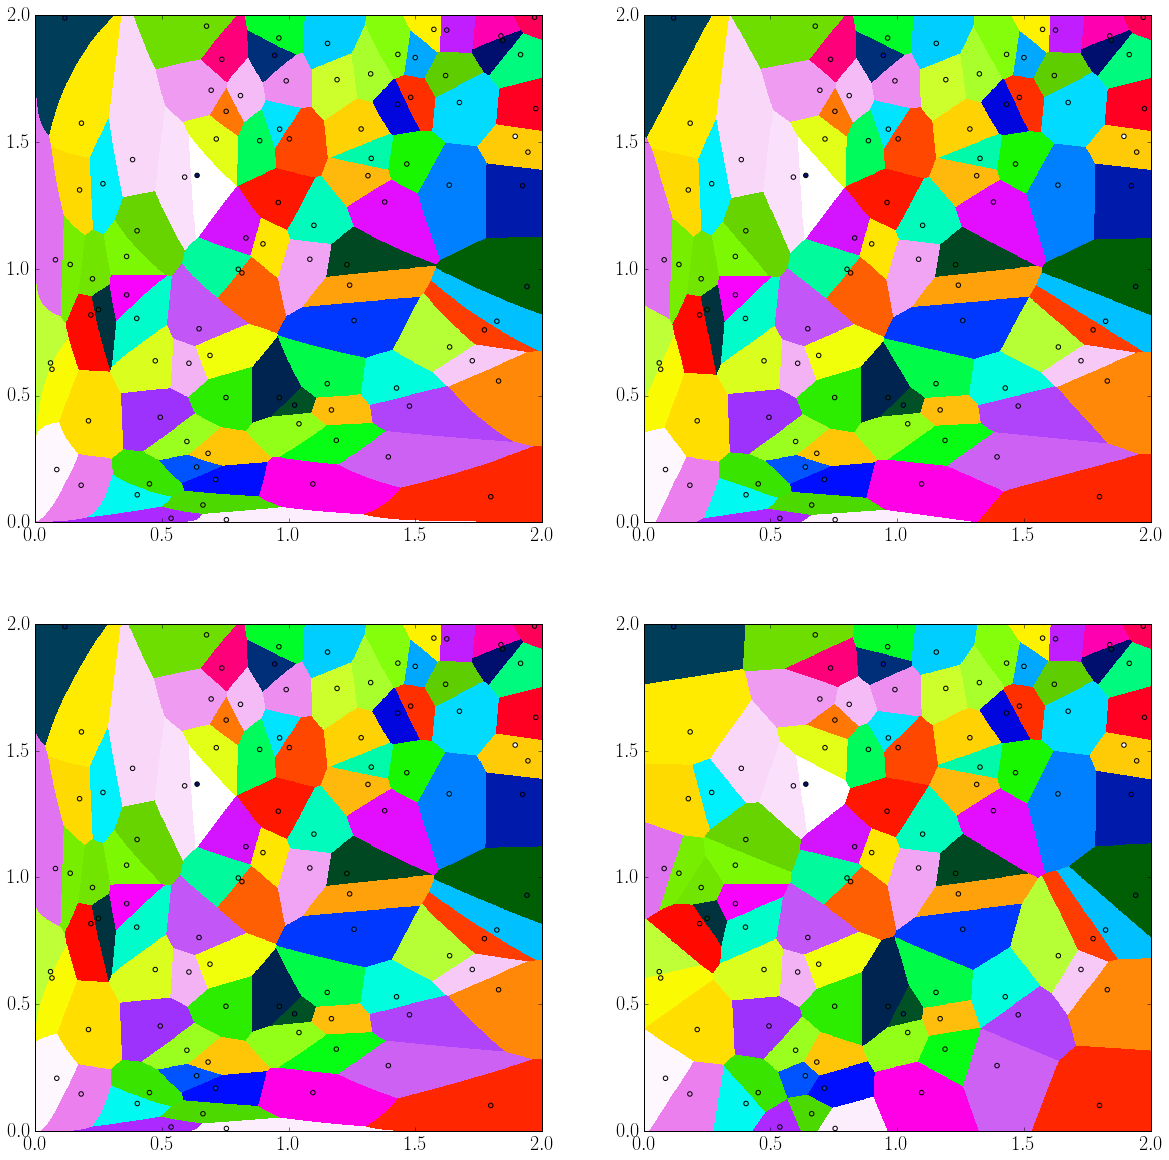

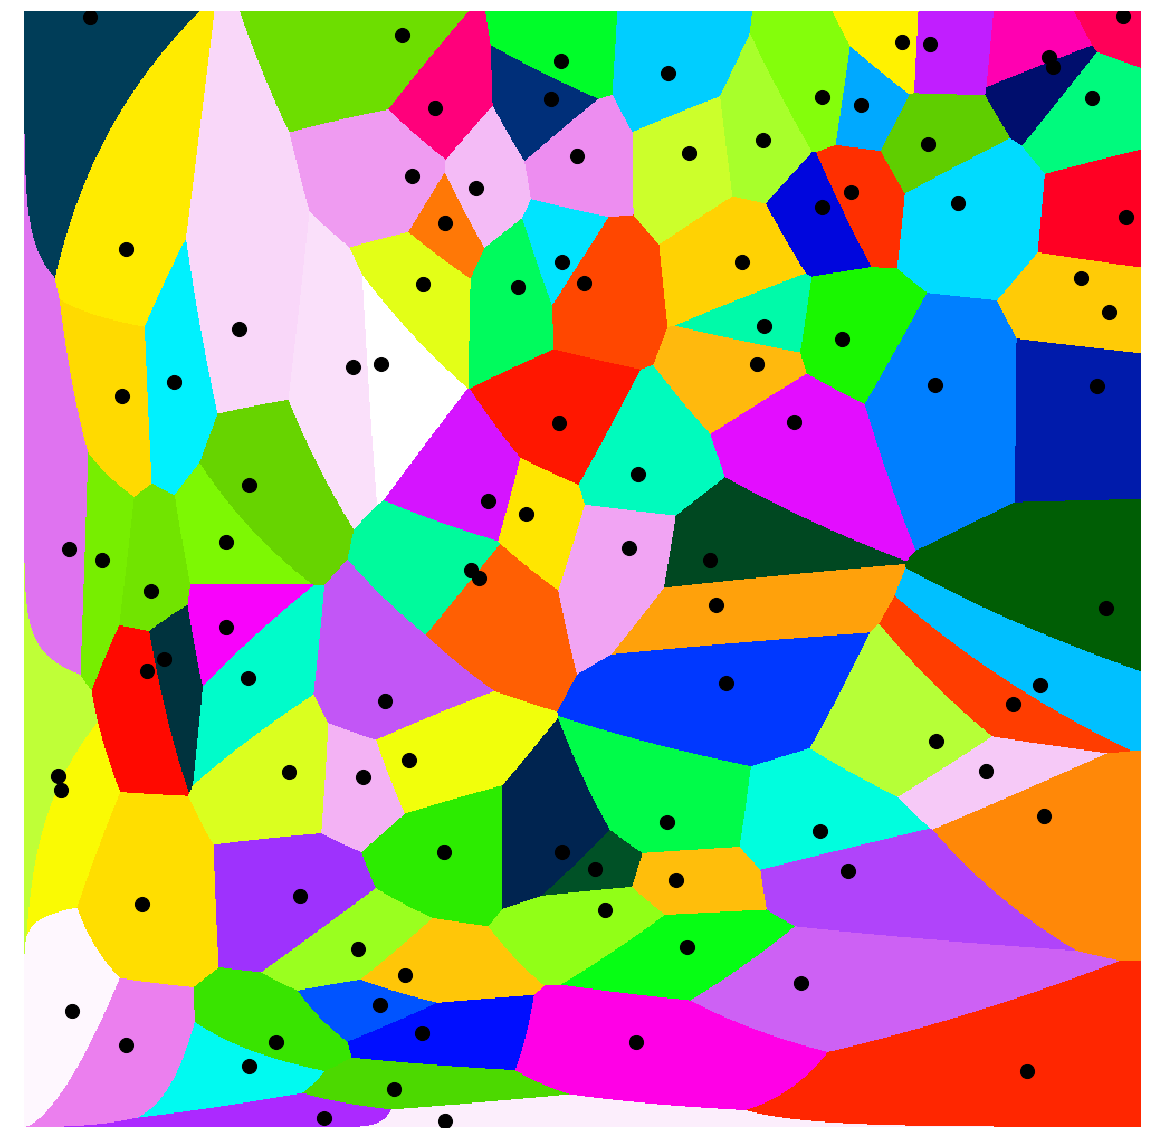

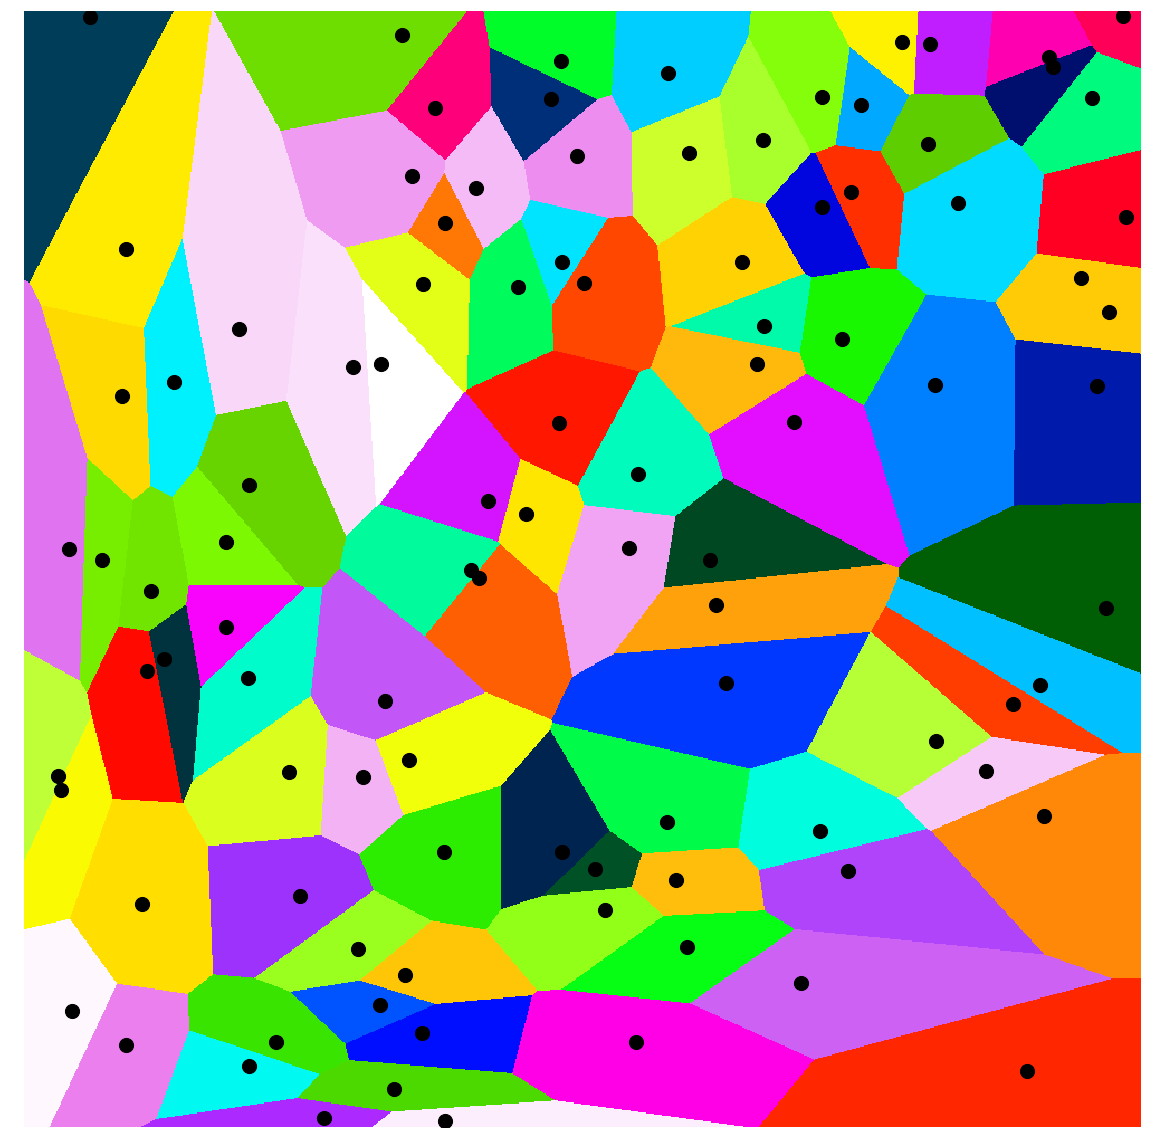

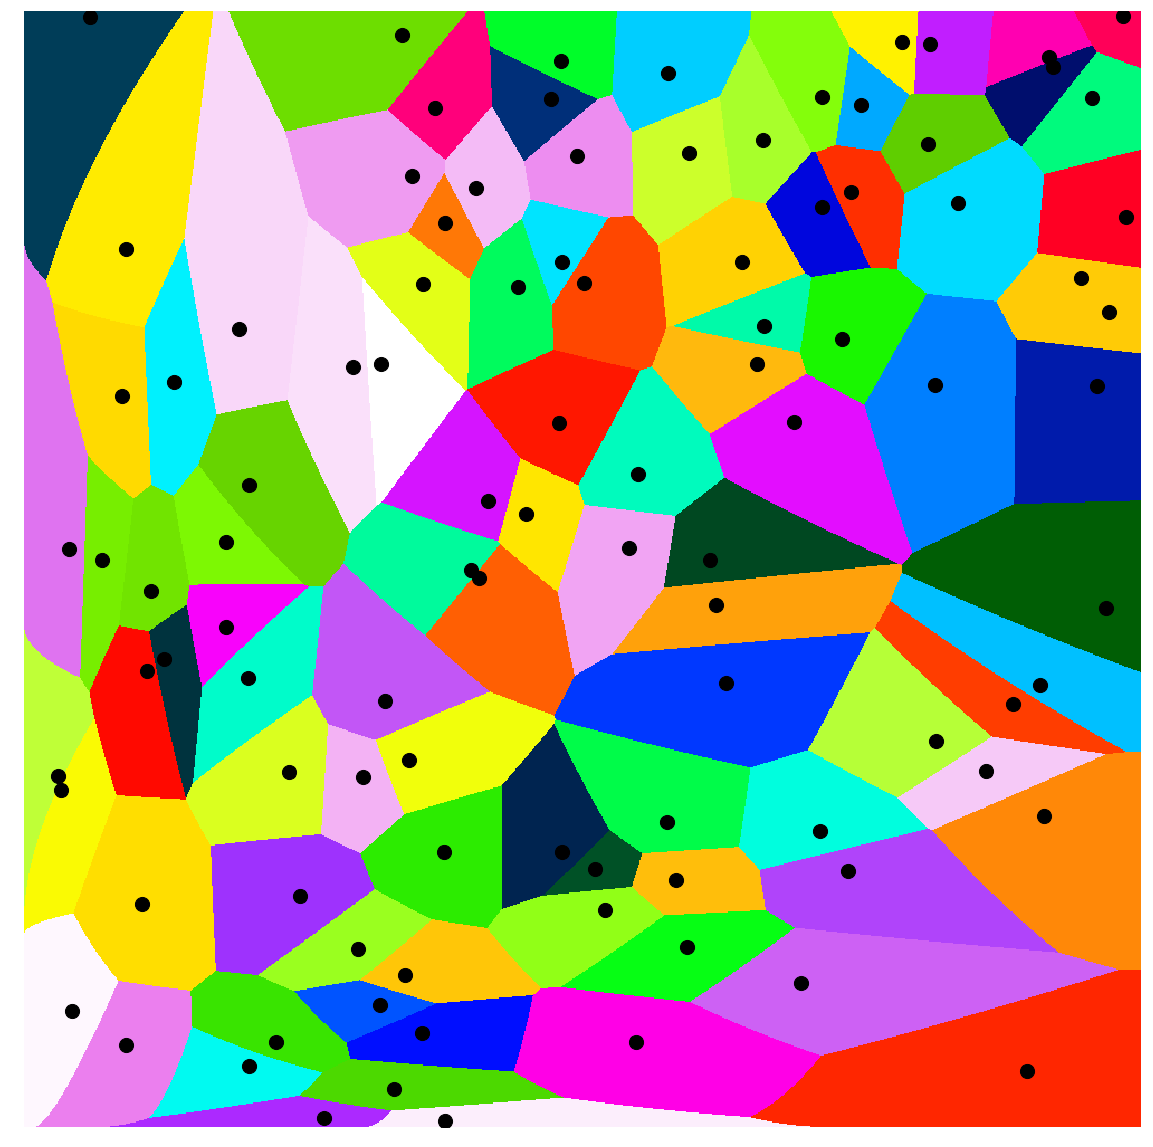

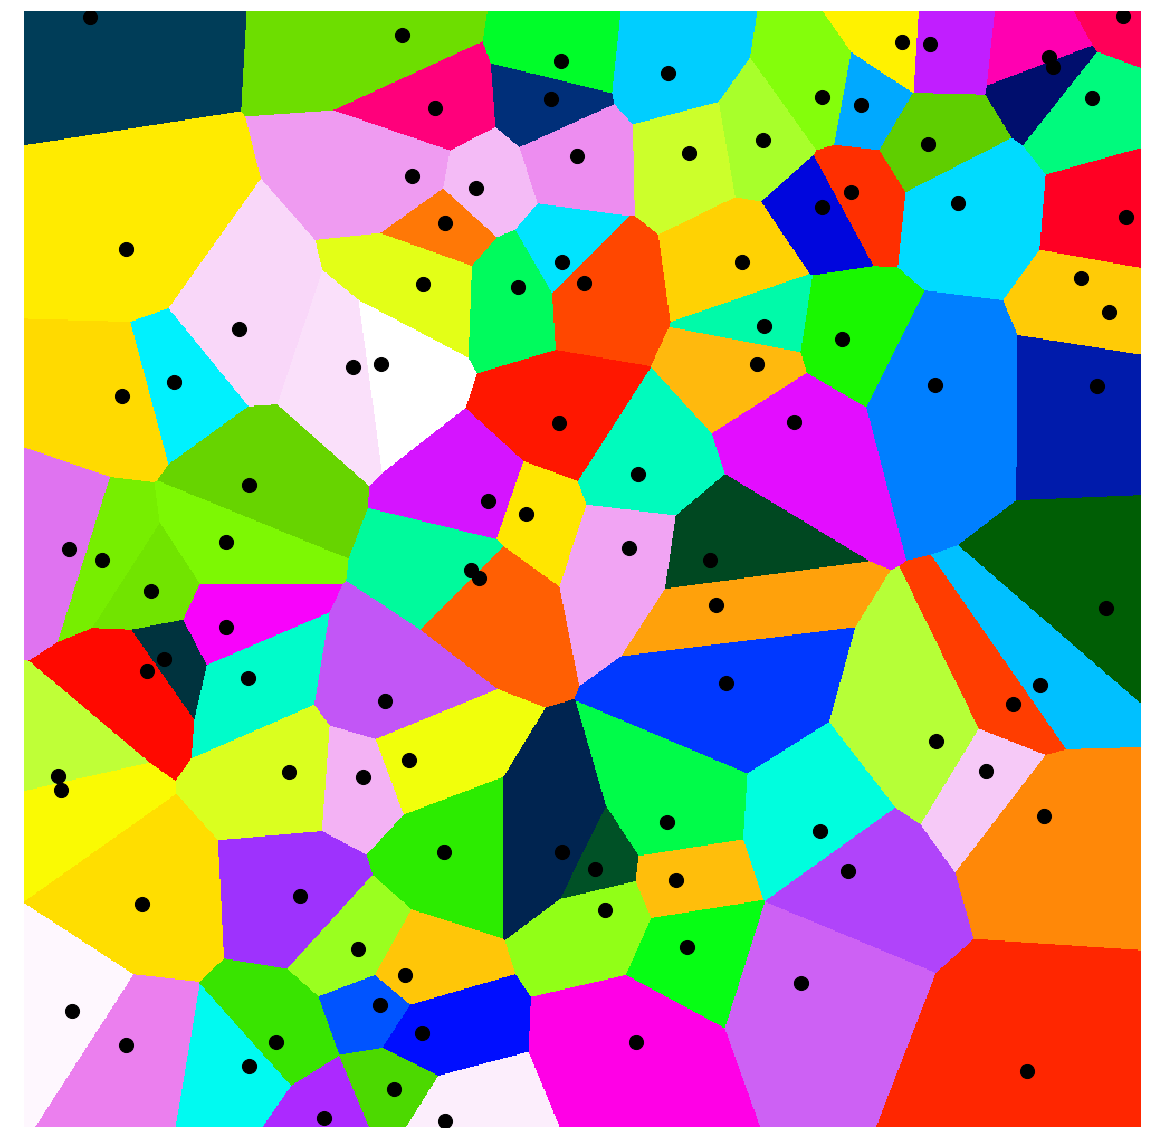

In [12]:
plt.rcParams["figure.figsize"] = (20,20)
draw_all_approximate_voronoi(filename,directory,1000,export=True,green=False)

# 6. Bregman-Delaunay triangulations

* start interactive software with './wrap_2_3'

* load data: 'Input->Load points'
    * (0,2]^2: 'data_export/bregman_examples/paper_fisher2_2_1000.txt'
    * standard 2-simplex: 'data_export/bregman_examples/paper_sphere_1000.txt'
    
* adapt view 'View->Redraw'
    * (0,2]^2: Point size 0.005, input 0.0025, Line width 0.005, always use radius^2
    * standard 2-simplex: Point size 5, input 2, Line width 3, Rotate -45 -45 0, Rotate light source -135 -180 0, scale 0.6, translate view 0 -13, always use radius^2
    
* select subcomplex: use checkboxes for 'Alpha' or 'Wrap', use slider to choose r-value

* export image of complex 'View->Export PNG-image' or 'View->Export SVG-image'
 

*  compute in various geometries: 'Input->Recompute with ...'
    * Euclidean metric
    * Fisher metric
    * Bregman divergence: Shannon
        * primal balls -> Shannon
        * no primal balls -> conjugate Shannon
    * check 'standard 2-simplex' for standard 2-simplex
    * check 'restrict to domain' for Euclidean, Fisher, conjugate Shannon 

* color simplices depending on whether or not they belong to other Delaunay triangulation:
    1. store simplices of other Delaunay triangulation: 'Export->Export simplices'
    2. compute current triangulation with 'Input->Recompute with...'
    3. 'Operation->Highlight differencts' select file where simplices stored
    4. change colors 'View->Change colors' edges 'old point', triangles 'new point'

* color simplices by radius
    * 'View->Redraw': 
        * check 'color by radius', select 'Alpha'
        * choose 'Max value (plots)' 
            * (0,2]^2: 0.01
            * standard 2-simplex: 0.005
    * 'View->Change colors': 'Delaunay dark' black, 'Alpha dark' black, 'points' grey 128
    * (0,2]^: display Delaunay triangulation, not Alpha or Wrap

In [16]:
def jaccard_distance(filename1, filename2):
    datafile = open(filename1, 'r')
    datareader = csv.reader(datafile, delimiter = ',')
    next(datareader) #skiprow
    simplices1 = []
    for row in datareader:
        simplices1.append(row[3])
        
    datafile = open(filename2, 'r')
    datareader = csv.reader(datafile, delimiter = ',')
    next(datareader) #skiprow
    simplices2 = []
    for row in datareader:
        simplices2.append(row[3])
        
    simplices1=set(simplices1)
    simplices2=set(simplices2)
    intersect12 = simplices1.intersection(simplices2)
    difference = simplices1.difference(intersect12)
    
    #include empty set?
    size1 = len(simplices1)*1.
    size2 = len(simplices2)*1.
    size_intersection = len(intersect12)*1.
    
    return 1.-(size_intersection/(size1+size2-size_intersection))

In [17]:
def compute_jaccard_distance_for_folder(folder_with_input_files):
    simplices_files = os.listdir(folder_with_input_files)
    for i,file1 in enumerate(simplices_files):
        for j,file2 in enumerate(simplices_files):
            if i<j:
                jdist = jaccard_distance(folder_with_input_files+'/'+file1,folder_with_input_files+'/'+file2)
                print ', '.join((file1,file2,str(jdist)))

In [18]:
# store set of simplices for different geometries to file: 'Export->Export simplices'

In [19]:
compute_jaccard_distance_for_folder("../output/bregman_paper/paper/square_simplices")

simplices_Euclidean_culled.txt, simplices_Fisher_culled.txt, 0.471307120085
simplices_Euclidean_culled.txt, simplices_KLweightedEuclidean_primal.txt, 0.477040146943
simplices_Euclidean_culled.txt, simplices_KL_dual_culled.txt, 0.46840842442
simplices_Euclidean_culled.txt, simplices_KL_primal.txt, 0.477040146943
simplices_Fisher_culled.txt, simplices_KLweightedEuclidean_primal.txt, 0.0371784232365
simplices_Fisher_culled.txt, simplices_KL_dual_culled.txt, 0.0232990038832
simplices_Fisher_culled.txt, simplices_KL_primal.txt, 0.0371784232365
simplices_KLweightedEuclidean_primal.txt, simplices_KL_dual_culled.txt, 0.0562962962963
simplices_KLweightedEuclidean_primal.txt, simplices_KL_primal.txt, 0.0
simplices_KL_dual_culled.txt, simplices_KL_primal.txt, 0.0562962962963


In [20]:
compute_jaccard_distance_for_folder("../output/bregman_paper/paper/simplex_simplices")

simplices_Euclidean_culled.txt, simplices_Fisher_culled.txt, 0.514995375875
simplices_Euclidean_culled.txt, simplices_KLweightedEuclidean_primal.txt, 0.522830164274
simplices_Euclidean_culled.txt, simplices_KL_dual_culled.txt, 0.512140108797
simplices_Euclidean_culled.txt, simplices_KL_primal.txt, 0.522830164274
simplices_Fisher_culled.txt, simplices_KLweightedEuclidean_primal.txt, 0.062015503876
simplices_Fisher_culled.txt, simplices_KL_dual_culled.txt, 0.0387359836901
simplices_Fisher_culled.txt, simplices_KL_primal.txt, 0.062015503876
simplices_KLweightedEuclidean_primal.txt, simplices_KL_dual_culled.txt, 0.0973709834469
simplices_KLweightedEuclidean_primal.txt, simplices_KL_primal.txt, 0.0
simplices_KL_dual_culled.txt, simplices_KL_primal.txt, 0.0973709834469


In [22]:
def count_inversions(filename1, filename2):
    datafile = open(filename1, 'r')
    datareader = csv.reader(datafile, delimiter = ',')
    next(datareader) #skiprow
    simplices1 = []
    
    for row in datareader:
        simplices1.append((float(row[1]),row[3]))
        
    datafile = open(filename2, 'r')
    datareader = csv.reader(datafile, delimiter = ',')
    next(datareader) #skiprow
    simplices2 = []
    for row in datareader:
        simplices2.append((float(row[1]),row[3]))
        
    simplices1.sort()
    simplices2.sort()
    ordered_pairs_of_simplices1 = []
    reverse_ordered_pairs_of_simplices2 = []
    
    for i in range(len(simplices1)):
        for j in range(len(simplices1)-i-1):
            s1 = simplices1[i]
            s2 = simplices1[j+i+1]
            if(s1[0]!=s2[0]):
                ordered_pairs_of_simplices1.append((s1[1],s2[1]))
    for i in range(len(simplices2)):
        for j in range(len(simplices2)-i-1):
            s1 = simplices2[i]
            s2 = simplices2[j+i+1]
            if(s1[0]!=s2[0]):
                reverse_ordered_pairs_of_simplices2.append((s2[1],s1[1]))
    
    ordered_pairs_of_simplices1 = set(ordered_pairs_of_simplices1)
    reverse_ordered_pairs_of_simplices2 = set(reverse_ordered_pairs_of_simplices2)
    inversions = ordered_pairs_of_simplices1.intersection(reverse_ordered_pairs_of_simplices2)
    num_pairs = (len(simplices1)*(len(simplices1)-1))/2.
    print len(inversions), num_pairs, len(inversions)/num_pairs
    return len(inversions), num_pairs, len(inversions)/num_pairs

In [ ]:
#it is faster to run .py-file from command line

example = "square" #8459354 17775703.0 0.475894202328
#example = "simplex" #8308791 17787630.0 0.467110626879
count_inversions("../output/bregman_paper/paper/"+example+"_simplices/simplices_KL_primal.txt","../output/bregman_paper/paper/"+example+"_simplices/simplices_KLweightedEuclidean_primal.txt")

# 7. Conclusion: Flower example

* start interactive software with './wrap_2_3'

* load data: 'Input->Load points'
    * file: 'data_mytests/flower1.txt'
    
* adapt view 'View->Redraw'
    * 2D: Point size 2, Line width 3
    
* select subcomplex: use checkboxes for 'Alpha' or 'Wrap', use slider to choose r-value

* export image of complex 'View->Export PNG-image' or 'View->Export SVG-image'
  
* export image of persistence diagram 'View->Export persistence diagram'

* color by Alpha/Wrap radius: 'View->Redraw->color by radius:Alpha/Wrap'
     * change 'Max value (plots)': 100 (=> everything with bigger radius white)
* relaxed Wrap complex: 'Operation->Recompute with threshold'
     * select 'infinity'

* test dynamic insertion: 'Input->Load points (test ...)->Test dynamic runtime'

In [7]:
#load and process raw data

def load_output_data_incremental(filename):
    
    t0 = time.clock()
    
    data = [] #all data will be stored in this
    
    load_data1(filename,data) 
    
    #initialize arrays
    t_add_local = []
    t_add_global = []
    
    other_statistics_titles = []
    other_statistics_data = []
    
    #num_points = data[0][1]
    
    #for every trial
    
    #first trial, get statistics titles
    current_row_index = 4
    while((not data[current_row_index][0].startswith("TIME")) and (current_row_index < (len(data)-1))):
        other_statistics_titles.append(data[current_row_index][0]);
        other_statistics_data.append([np.sum(data[current_row_index][1:])])
        current_row_index += 1
    #get time
    t_add_local.append(data[current_row_index][1])
    t_add_global.append(data[current_row_index+1][1])
    current_row_index += 4
    
    #all trials
    while(current_row_index<len(data)-1-len(other_statistics_titles)):
        for i in range(len(other_statistics_titles)):
            other_statistics_data[i].append(np.sum(data[current_row_index][1:]))
            current_row_index += 1
        if(current_row_index<len(data)-1):
            t_add_local.append(data[current_row_index][1])
            t_add_global.append(data[current_row_index+1][1])
        current_row_index += 4
        
    num_points = len(t_add_local)+5

    #duration = time.clock() - t0; print 'time elapsed: %.4f' % duration
    
    return t_add_local, t_add_global, num_points, other_statistics_titles, other_statistics_data

def plot_times_incremental(filename_without_txt):
    t_add_local, t_add_global, num_points, other_statistics_titles, other_statistics_data = load_output_data_incremental(filename_without_txt+'.txt')
    plt.plot(range(6,num_points+1),t_add_global,label='global',lw=2,color=colors[1])
    plt.plot(range(6,num_points+1),t_add_local,label='local',lw=2,color=colors[0])
    #plt.title('Running times for incremental point addition',fontsize=20)
    plt.legend(fontsize=30,loc = 'upper left')
    plt.ylabel('time [s]',fontsize=40)
    plt.xlabel('\# points',fontsize=40)
    plt.ylim([0,np.max(t_add_global)*1.1])
    plt.tick_params(axis='both', which='major', labelsize=30)
    plt.savefig(filename_without_txt+".eps", bbox_inches='tight', format='eps', dpi=1000)
    plt.show()

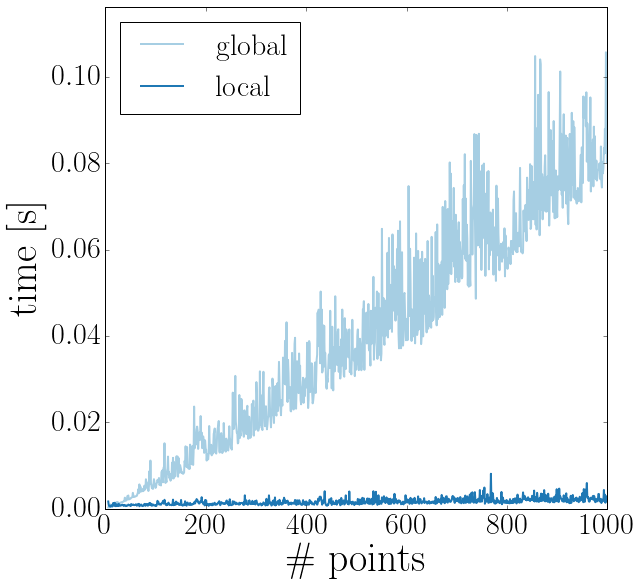

In [8]:
plt.rcParams['figure.figsize'] = (9,9)
plot_times_incremental('../output/thesis/flower_dynamic_insertion')
plt.rcParams['figure.figsize'] = (9,7)


* export data for curves: 'Export->Export interval statistics'

In [9]:
def plot_statistics_curves(filename,dim,maxr,results_folder,maxbetti=-1,name='example',linewidth=2):

    param = {} #dictionary for parameters
    data = [] #all data will be stored in this
    headers = [] #this array will store rows containing strings together with their row index

    load_data2(flower_file,data,headers,param,True)

    current_header_index = -1
    #get data for every interval: r_alpha, r_wrap, lower dimension, upper dimension
    # for singular intervals also: positive?, persistence, # simplices in lower set, # nested lower sets, diameter of simplex, diameter of lower set
    # get first row index
    current_header_index = get_current_header_index(current_header_index,'r_alpha',headers)
    header = headers[current_header_index][1]
    rowindex = headers[current_header_index][0]+1   
    # get data
    intervals_data = data[rowindex:headers[current_header_index+1][0]]

    alpha_radii = set()
    for i,interval_data in enumerate(intervals_data):
        alpha_radii.add(interval_data[0])
    alpha_radii = sorted(alpha_radii)  

    radius_indices = {}
    for i,radius in enumerate(alpha_radii):
        radius_indices[radius]=i

    num_alpha_simplices = np.zeros((len(alpha_radii),4))
    num_wrap_simplices = np.zeros((len(alpha_radii),4))
    betti_num = np.zeros((len(alpha_radii),3))
    current_betti_num = np.zeros((1,3))

    for i,interval_data in enumerate(intervals_data):
        r_alpha = interval_data[0]
        r_wrap = interval_data[1]
        lower_dim = interval_data[2]
        upper_dim = interval_data[3]
        alpha_radius_index = radius_indices[r_alpha]
        wrap_radius_index = radius_indices[r_wrap]
        if lower_dim==upper_dim: # critical
            if upper_dim==0:
                positive = True
            else:
                positive = interval_data[4]
            if(positive):
                current_betti_num[0,lower_dim]=current_betti_num[0,lower_dim]+1;
            else:
                current_betti_num[0,lower_dim-1]=current_betti_num[0,lower_dim-1]-1;
            num_alpha_simplices[alpha_radius_index,lower_dim]=num_alpha_simplices[alpha_radius_index,lower_dim]+1;
            num_wrap_simplices[wrap_radius_index,lower_dim]=num_wrap_simplices[wrap_radius_index,lower_dim]+1;
        else: #non-critical
            if upper_dim==3:
                num_alpha_simplices[alpha_radius_index,3]=num_alpha_simplices[alpha_radius_index,3]+1;
                if r_wrap>0:
                    num_wrap_simplices[wrap_radius_index,3]=num_wrap_simplices[wrap_radius_index,3]+1;
                if lower_dim==2:
                    num_alpha_simplices[alpha_radius_index,2]=num_alpha_simplices[alpha_radius_index,2]+1;
                    if r_wrap>0:
                        num_wrap_simplices[wrap_radius_index,2]=num_wrap_simplices[wrap_radius_index,2]+1;
                elif lower_dim==1:
                    num_alpha_simplices[alpha_radius_index,2]=num_alpha_simplices[alpha_radius_index,2]+2;
                    if r_wrap>0:
                        num_wrap_simplices[wrap_radius_index,2]=num_wrap_simplices[wrap_radius_index,2]+2;
                    num_alpha_simplices[alpha_radius_index,1]=num_alpha_simplices[alpha_radius_index,1]+1;
                    if r_wrap>0:
                        num_wrap_simplices[wrap_radius_index,1]=num_wrap_simplices[wrap_radius_index,1]+1;
            elif upper_dim==2:
                num_alpha_simplices[alpha_radius_index,2]=num_alpha_simplices[alpha_radius_index,2]+1;
                if r_wrap>0:
                    num_wrap_simplices[wrap_radius_index,2]=num_wrap_simplices[wrap_radius_index,2]+1;
                # lower_dim==1:
                num_alpha_simplices[alpha_radius_index,1]=num_alpha_simplices[alpha_radius_index,1]+1;
                if r_wrap>0:
                    num_wrap_simplices[wrap_radius_index,1]=num_wrap_simplices[wrap_radius_index,1]+1;
        betti_num[alpha_radius_index]=current_betti_num

    cumsum_alpha_simplices = np.cumsum(num_alpha_simplices,axis=0)
    cumsum_wrap_simplices = np.cumsum(num_wrap_simplices,axis=0)
    
    
    colors = colors7

    plt.figure(0)
    plt.ylabel('\# simplices', fontsize=22)
    plt.xlabel('$r$', fontsize=22)
    ax = plt.gca()
    ax.tick_params(axis='both', which='major', labelsize=20)

    labels_wrap = [str(d)+' Wrap' for d in range(dim+1)]
    labels_alpha = [str(d)+' Alpha' for d in range(dim+1)]
    for d in range(dim+1):
        if d!=0:
            plt.plot(alpha_radii,cumsum_alpha_simplices[:,d],label=labels_alpha[d],lw=linewidth,linestyle='--',color=colors[d-1])
            plt.plot(alpha_radii,cumsum_wrap_simplices[:,d],label=labels_wrap[d],lw=linewidth,color=colors[d-1])
    plt.legend(fontsize=20,loc="lower right")
    plt.xlim(0,maxr)
    plt.savefig(results_folder+'plot_num_simplices_'+name+'.eps', bbox_inches='tight', format='eps', dpi=1000)
    plt.show()

    plt.figure(1)
    plt.ylabel('Betti numbers', fontsize=22)
    plt.xlabel('$r$', fontsize=22)
    ax = plt.gca()
    ax.tick_params(axis='both', which='major', labelsize=20)

    labels_betti = [r'$\beta_'+str(d)+'$' for d in range(dim)]
    linestyles = ['-']*(dim)
    for d in range(dim):
        plt.plot(alpha_radii,betti_num[:,d],label=labels_betti[d],lw=linewidth,color=colors[d])
    plt.legend(fontsize=20)
    plt.xlim(0,maxr)
    if maxbetti>0:
        plt.ylim(0,maxbetti)
    plt.savefig(results_folder+'plot_betti_'+name+'.eps', bbox_inches='tight', format='eps', dpi=1000)
    plt.show()
    
    return alpha_radii, cumsum_alpha_simplices, cumsum_wrap_simplices, betti_num

../output/thesis/flower_intervals.txt


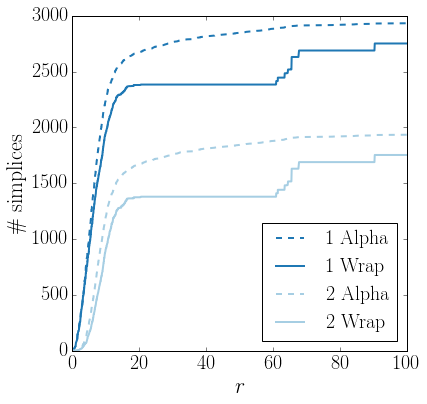

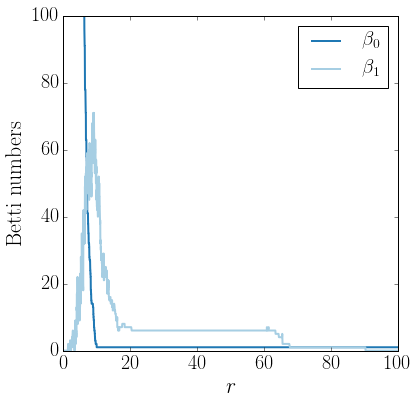

In [10]:
flower_file='../output/thesis/flower_intervals.txt'
name='flower'
results_folder='../output/thesis/'
dim=2
maxr=100

plt.rcParams['figure.figsize'] = (6,6) 
alpha_radii, cumsum_alpha_simplices, cumsum_wrap_simplices, betti_num=plot_statistics_curves(flower_file,dim,maxr,results_folder,name=name,maxbetti=100);

* highlight 1-tree: 'Operation->Highlight p-tree'
* highlight canonical (co)cycle: 'Operation->Hole Operation'
     * choose dimension
     * lock=cycle, unfill=cocycle 
     * select 'Highlight'

* Hole operations: see above

* Bregman geometry: see above